In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
DATASET_ROOT = "/content/drive/MyDrive/papilloedema"


In [ ]:
import os

print(os.listdir(DATASET_ROOT))


['N', 'G5', 'G2', 'G4', 'G3', 'G1', 'Pseudopapilledema']


In [ ]:
from collections import defaultdict

image_counts = defaultdict(int)

for cls in os.listdir(DATASET_ROOT):
    cls_path = os.path.join(DATASET_ROOT, cls)
    if os.path.isdir(cls_path):
        for f in os.listdir(cls_path):
            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff')):
                image_counts[cls] += 1

image_counts


defaultdict(int,
            {'N': 28,
             'G5': 2,
             'G2': 44,
             'G4': 14,
             'G3': 26,
             'G1': 171,
             'Pseudopapilledema': 295})

In [ ]:
import pandas as pd

records = []

for cls in os.listdir(DATASET_ROOT):
    cls_path = os.path.join(DATASET_ROOT, cls)
    if not os.path.isdir(cls_path):
        continue

    for img in os.listdir(cls_path):
        if not img.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff')):
            continue

        full_path = os.path.join(cls_path, img)

        if cls in ['N', 'Pseudopapilledema']:
            detect = 0
            stage = -1
        else:
            detect = 1
            stage = int(cls[1])  # G1 → 1, G2 → 2

        records.append({
            "path": full_path,
            "detect": detect,
            "stage": stage
        })

df = pd.DataFrame(records)
df.head()


path  detect  stage
0  /content/drive/MyDrive/papilloedema/N/IM000041...       0     -1
1  /content/drive/MyDrive/papilloedema/N/IM000043...       0     -1
2  /content/drive/MyDrive/papilloedema/N/IM000044...       0     -1
3  /content/drive/MyDrive/papilloedema/N/IM000046...       0     -1
4  /content/drive/MyDrive/papilloedema/N/IM000042...       0     -1

In [ ]:
df.groupby(["detect", "stage"]).size()


detect  stage
0       -1       323
1        1       171
         2        44
         3        26
         4        14
         5         2
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

# First split: train vs temp (val + test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["detect"],
    random_state=42
)

# Second split: val vs test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["detect"],
    random_state=42
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))


Train: 406
Val: 87
Test: 87


In [ ]:
def check_distribution(df, name):
    print(f"\n{name} Detection Distribution")
    print(df["detect"].value_counts(normalize=True))

check_distribution(train_df, "Train")
check_distribution(val_df, "Val")
check_distribution(test_df, "Test")



Train Detection Distribution
detect
0    0.55665
1    0.44335
Name: proportion, dtype: float64

Val Detection Distribution
detect
0    0.551724
1    0.448276
Name: proportion, dtype: float64

Test Detection Distribution
detect
0    0.563218
1    0.436782
Name: proportion, dtype: float64


In [ ]:
print("\nTrain Stage Distribution")
print(train_df[train_df.detect == 1]["stage"].value_counts())



Train Stage Distribution
stage
1    121
2     31
3     20
4      6
5      2
Name: count, dtype: int64


In [ ]:
SPLIT_DIR = "/content/drive/MyDrive/papilloedema_splits"
os.makedirs(SPLIT_DIR, exist_ok=True)

train_df.to_csv(f"{SPLIT_DIR}/train.csv", index=False)
val_df.to_csv(f"{SPLIT_DIR}/val.csv", index=False)
test_df.to_csv(f"{SPLIT_DIR}/test.csv", index=False)


In [ ]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.LongestMaxSize(max_size=512),
    A.PadIfNeeded(512, 512, border_mode=0),
    A.RandomCrop(448, 448),

    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),

    A.RandomBrightnessContrast(p=0.4),
    A.CLAHE(p=0.3),
    A.GaussianBlur(blur_limit=3, p=0.2),

    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])


In [ ]:
val_transform = A.Compose([
    A.LongestMaxSize(max_size=512),
    A.PadIfNeeded(512, 512, border_mode=0),
    A.CenterCrop(448, 448),

    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])


In [ ]:
import cv2
import torch
from torch.utils.data import Dataset

class PapilledemaDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["path"]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)["image"]

        detect = torch.tensor(row["detect"], dtype=torch.float32)
        stage  = torch.tensor(row["stage"], dtype=torch.long)

        return image, detect, stage


In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8  # Safe for 448x448 on T4 GPU

train_ds = PapilledemaDataset(train_df, train_transform)
val_ds   = PapilledemaDataset(val_df, val_transform)
test_ds  = PapilledemaDataset(test_df, val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [ ]:
images, detect, stage = next(iter(train_loader))
print(images.shape)
print(detect[:5])
print(stage[:5])


torch.Size([8, 3, 448, 448])
tensor([1., 1., 0., 0., 0.])
tensor([ 1,  1, -1, -1, -1])


In [ ]:
import timm
import torch.nn as nn

class DetectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
            "efficientnet_b4",
            pretrained=True,
            num_classes=0  # removes classifier
        )

        self.head = nn.Sequential(
            nn.Linear(self.backbone.num_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)  # binary output
        )

    def forward(self, x):
        features = self.backbone(x)
        logits = self.head(features)
        return logits.squeeze(1)


In [ ]:
import torch

num_pos = train_df["detect"].sum()
num_neg = len(train_df) - num_pos

pos_weight = torch.tensor([num_neg / num_pos]).cuda()
pos_weight


tensor([1.2556], device='cuda:0', dtype=torch.float64)

In [ ]:
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


In [ ]:
import torch.optim as optim

model = DetectionModel().cuda()

optimizer = optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

In [ ]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=2,
    verbose=True
)


TypeError: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'

In [ ]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=2
)


In [ ]:
from sklearn.metrics import roc_auc_score, recall_score
import numpy as np


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for images, detect, _ in loader:
        images = images.cuda()
        detect = detect.cuda()

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, detect)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [ ]:
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, detect, _ in loader:
            images = images.cuda()
            detect = detect.cuda()

            logits = model(images)
            loss = criterion(logits, detect)

            probs = torch.sigmoid(logits)

            all_preds.extend(probs.cpu().numpy())
            all_targets.extend(detect.cpu().numpy())
            total_loss += loss.item()

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    auc = roc_auc_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds > 0.5)

    return total_loss / len(loader), auc, recall


In [ ]:
EPOCHS = 20
best_auc = 0

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_auc, val_recall = validate(model, val_loader, criterion)

    scheduler.step(val_auc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"Val AUC:    {val_auc:.4f}")
    print(f"Val Recall: {val_recall:.4f}")

    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(),
                   "/content/drive/MyDrive/best_detection_model.pth")
        print("✅ Best model saved")


Epoch 1/20
Train Loss: 0.3576
Val Loss:   0.2140
Val AUC:    0.9674
Val Recall: 1.0000
✅ Best model saved
Epoch 2/20
Train Loss: 0.1830
Val Loss:   0.1888
Val AUC:    0.9738
Val Recall: 1.0000
✅ Best model saved
Epoch 3/20
Train Loss: 0.1177
Val Loss:   0.1488
Val AUC:    0.9802
Val Recall: 1.0000
✅ Best model saved
Epoch 4/20
Train Loss: 0.1130
Val Loss:   0.1011
Val AUC:    0.9947
Val Recall: 1.0000
✅ Best model saved
Epoch 5/20
Train Loss: 0.0984
Val Loss:   0.1218
Val AUC:    0.9856
Val Recall: 1.0000
Epoch 6/20
Train Loss: 0.0650
Val Loss:   0.1461
Val AUC:    0.9861
Val Recall: 1.0000
Epoch 7/20
Train Loss: 0.0766
Val Loss:   0.1817
Val AUC:    0.9722
Val Recall: 1.0000
Epoch 8/20
Train Loss: 0.0369
Val Loss:   0.1581
Val AUC:    0.9802
Val Recall: 1.0000
Epoch 9/20
Train Loss: 0.1154
Val Loss:   0.1573
Val AUC:    0.9792
Val Recall: 1.0000
Epoch 10/20
Train Loss: 0.0547
Val Loss:   0.1593
Val AUC:    0.9824
Val Recall: 1.0000
Epoch 11/20
Train Loss: 0.0397
Val Loss:   0.1391
Val

In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Recreate the model class if not in memory
import timm
import torch.nn as nn

class DetectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model("efficientnet_b4", pretrained=False, num_classes=0)
        self.head = nn.Sequential(
            nn.Linear(self.backbone.num_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        features = self.backbone(x)
        logits = self.head(features)
        return logits.squeeze(1)

det_model = DetectionModel().cuda()
det_model.load_state_dict(torch.load("/content/drive/MyDrive/best_detection_model.pth"))
det_model.eval()
print("✅ Loaded best detection model")


✅ Loaded best detection model


In [ ]:
@torch.no_grad()
def get_detection_preds(model, loader, threshold=0.5):
    model.eval()
    all_probs, all_true = [], []

    for images, detect, _ in loader:
        images = images.cuda()
        logits = model(images)
        probs = torch.sigmoid(logits).cpu().numpy()

        all_probs.extend(probs.tolist())
        all_true.extend(detect.numpy().tolist())

    all_probs = np.array(all_probs)
    all_true = np.array(all_true).astype(int)
    all_pred = (all_probs >= threshold).astype(int)
    return all_true, all_pred, all_probs


In [ ]:
y_true, y_pred, y_prob = get_detection_preds(det_model, test_loader, threshold=0.5)

print("=== Detection: Classification Report (TEST) ===")
print(classification_report(
    y_true, y_pred,
    target_names=["Non-papilledema (N+Pseudo)", "Papilledema (G1–G5)"],
    digits=4
))


=== Detection: Classification Report (TEST) ===
                            precision    recall  f1-score   support

Non-papilledema (N+Pseudo)     1.0000    0.9388    0.9684        49
       Papilledema (G1–G5)     0.9268    1.0000    0.9620        38

                  accuracy                         0.9655        87
                 macro avg     0.9634    0.9694    0.9652        87
              weighted avg     0.9680    0.9655    0.9656        87



In [ ]:
def print_detection_accs(model, train_loader, val_loader, test_loader, threshold=0.5):
    for name, loader in [("Train", train_loader), ("Val", val_loader), ("Test", test_loader)]:
        y_true, y_pred, _ = get_detection_preds(model, loader, threshold)
        acc = accuracy_score(y_true, y_pred)
        print(f"{name} Accuracy: {acc:.4f}")

print("=== Detection: Accuracies ===")
print_detection_accs(det_model, train_loader, val_loader, test_loader, threshold=0.5)


=== Detection: Accuracies ===
Train Accuracy: 1.0000
Val Accuracy: 0.9770
Test Accuracy: 0.9655


In [ ]:
stage_train_df = train_df[train_df.detect == 1].reset_index(drop=True)
stage_val_df   = val_df[val_df.detect == 1].reset_index(drop=True)
stage_test_df  = test_df[test_df.detect == 1].reset_index(drop=True)

print("Stage Train:", len(stage_train_df))
print("Stage Val:  ", len(stage_val_df))
print("Stage Test: ", len(stage_test_df))

print("\nTrain stage counts:\n", stage_train_df["stage"].value_counts().sort_index())
print("\nVal stage counts:\n", stage_val_df["stage"].value_counts().sort_index())


Stage Train: 180
Stage Val:   39
Stage Test:  38

Train stage counts:
 stage
1    121
2     31
3     20
4      6
5      2
Name: count, dtype: int64

Val stage counts:
 stage
1    23
2     7
3     2
4     7
Name: count, dtype: int64


In [ ]:
import cv2
import torch
from torch.utils.data import Dataset

class PapilledemaStageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["path"]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)["image"]

        # stages are 1..5
        stage = torch.tensor(row["stage"], dtype=torch.long)
        return image, stage


In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE_STAGE = 8

stage_train_ds = PapilledemaStageDataset(stage_train_df, train_transform)
stage_val_ds   = PapilledemaStageDataset(stage_val_df, val_transform)
stage_test_ds  = PapilledemaStageDataset(stage_test_df, val_transform)

stage_train_loader = DataLoader(stage_train_ds, batch_size=BATCH_SIZE_STAGE, shuffle=True, num_workers=2)
stage_val_loader   = DataLoader(stage_val_ds, batch_size=BATCH_SIZE_STAGE, shuffle=False, num_workers=2)
stage_test_loader  = DataLoader(stage_test_ds, batch_size=BATCH_SIZE_STAGE, shuffle=False, num_workers=2)


In [ ]:
x, y = next(iter(stage_train_loader))
print(x.shape, y[:10])


torch.Size([8, 3, 448, 448]) tensor([1, 1, 1, 3, 2, 1, 1, 1])


In [ ]:
def coral_encode(stage_labels, num_classes=5):
    # stage_labels: tensor [B] with values 1..5
    # returns: [B, 4] float targets
    B = stage_labels.shape[0]
    targets = torch.zeros((B, num_classes - 1), device=stage_labels.device, dtype=torch.float32)
    for i, y in enumerate(stage_labels):
        targets[i, : (y.item() - 1)] = 1.0
    return targets

def coral_decode(logits):
    # logits: [B,4]
    probs = torch.sigmoid(logits)
    # predict grade = 1 + number of thresholds passed
    pred = 1 + (probs > 0.5).sum(dim=1)
    return pred


In [ ]:
import numpy as np
import torch

# compute pos_weight for each threshold using training distribution
stages = stage_train_df["stage"].values  # 1..5
# threshold targets: t1 means >=2, t2 >=3, t3 >=4, t4 >=5
targets_np = np.zeros((len(stages), 4), dtype=np.float32)
for i, y in enumerate(stages):
    targets_np[i, : (y - 1)] = 1.0

pos_counts = targets_np.sum(axis=0)
neg_counts = len(stages) - pos_counts
pos_weight_vec = torch.tensor(neg_counts / np.maximum(pos_counts, 1.0), dtype=torch.float32).cuda()

print("pos_weight_vec (t1..t4):", pos_weight_vec)


pos_weight_vec (t1..t4): tensor([ 2.0508,  5.4286, 21.5000, 89.0000], device='cuda:0')


In [ ]:
criterion_stage = nn.BCEWithLogitsLoss(pos_weight=pos_weight_vec)


In [ ]:
import timm
import torch
import torch.nn as nn

class StagingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
            "efficientnet_b4",
            pretrained=True,   # use pretrained during training
            num_classes=0
        )
        self.head = nn.Sequential(
            nn.Linear(self.backbone.num_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 4)  # CORAL ordinal logits
        )

    def forward(self, x):
        feat = self.backbone(x)
        return self.head(feat)

def coral_encode(stage_labels, num_classes=5):
    # stage_labels: tensor [B] with values 1..5
    B = stage_labels.shape[0]
    targets = torch.zeros((B, num_classes - 1), device=stage_labels.device, dtype=torch.float32)
    for i, y in enumerate(stage_labels):
        targets[i, : (y.item() - 1)] = 1.0
    return targets

def coral_decode(logits):
    probs = torch.sigmoid(logits)
    pred = 1 + (probs > 0.5).sum(dim=1)
    return pred


In [ ]:
from sklearn.metrics import cohen_kappa_score
import torch.optim as optim

stage_model = StagingModel().cuda()

optimizer_stage = optim.AdamW(stage_model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler_stage = optim.lr_scheduler.ReduceLROnPlateau(optimizer_stage, mode="max", factor=0.5, patience=2)

def train_one_epoch_stage(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for images, stage in loader:
        images = images.cuda()
        stage = stage.cuda()

        optimizer.zero_grad()
        logits = model(images)                  # [B,4]
        targets = coral_encode(stage)           # [B,4]
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

@torch.no_grad()
def validate_stage(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    all_true = []
    all_pred = []

    for images, stage in loader:
        images = images.cuda()
        stage = stage.cuda()

        logits = model(images)
        targets = coral_encode(stage)
        loss = criterion(logits, targets)
        total_loss += loss.item()

        pred_stage = coral_decode(logits)

        all_true.extend(stage.cpu().numpy().tolist())
        all_pred.extend(pred_stage.cpu().numpy().tolist())

    all_true = np.array(all_true)
    all_pred = np.array(all_pred)

    mae = np.mean(np.abs(all_true - all_pred))
    qwk = cohen_kappa_score(all_true, all_pred, weights="quadratic")
    acc = np.mean(all_true == all_pred)

    return total_loss / len(loader), mae, qwk, acc


In [ ]:
EPOCHS_STAGE = 25
best_qwk = -1

SAVE_PATH_STAGE = "/content/drive/MyDrive/best_staging_model_coral.pth"

for epoch in range(EPOCHS_STAGE):
    train_loss = train_one_epoch_stage(stage_model, stage_train_loader, optimizer_stage, criterion_stage)
    val_loss, val_mae, val_qwk, val_acc = validate_stage(stage_model, stage_val_loader, criterion_stage)

    scheduler_stage.step(val_qwk)

    lr_now = optimizer_stage.param_groups[0]["lr"]
    print(f"Epoch {epoch+1}/{EPOCHS_STAGE} | LR {lr_now:.6f}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val MAE: {val_mae:.4f} | Val QWK: {val_qwk:.4f} | Val Acc: {val_acc:.4f}")

    if val_qwk > best_qwk:
        best_qwk = val_qwk
        torch.save(stage_model.state_dict(), SAVE_PATH_STAGE)
        print("✅ Best staging model saved")


Epoch 1/25 | LR 0.000300
Train Loss: 1.0990
Val Loss:   1.4866 | Val MAE: 0.7692 | Val QWK: 0.4968 | Val Acc: 0.5128
✅ Best staging model saved
Epoch 2/25 | LR 0.000300
Train Loss: 0.8382
Val Loss:   1.1018 | Val MAE: 1.0256 | Val QWK: 0.5676 | Val Acc: 0.2821
✅ Best staging model saved
Epoch 3/25 | LR 0.000300
Train Loss: 0.6890
Val Loss:   0.8999 | Val MAE: 0.9744 | Val QWK: 0.5794 | Val Acc: 0.3333
✅ Best staging model saved
Epoch 4/25 | LR 0.000300
Train Loss: 0.5621
Val Loss:   0.7398 | Val MAE: 0.8462 | Val QWK: 0.6528 | Val Acc: 0.3846
✅ Best staging model saved
Epoch 5/25 | LR 0.000300
Train Loss: 0.5706
Val Loss:   0.7245 | Val MAE: 0.4615 | Val QWK: 0.8347 | Val Acc: 0.5897
✅ Best staging model saved
Epoch 6/25 | LR 0.000300
Train Loss: 0.4984
Val Loss:   0.6979 | Val MAE: 0.4103 | Val QWK: 0.8615 | Val Acc: 0.6410
✅ Best staging model saved
Epoch 7/25 | LR 0.000300
Train Loss: 0.4315
Val Loss:   0.7419 | Val MAE: 0.6667 | Val QWK: 0.7583 | Val Acc: 0.4359
Epoch 8/25 | LR 0.0

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

class StagingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model("efficientnet_b4", pretrained=False, num_classes=0)
        self.head = nn.Sequential(
            nn.Linear(self.backbone.num_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 4)  # CORAL
        )

    def forward(self, x):
        feat = self.backbone(x)
        return self.head(feat)

def coral_decode(logits):
    probs = torch.sigmoid(logits)
    pred = 1 + (probs > 0.5).sum(dim=1)
    return pred

stage_model = StagingModel().cuda()
stage_model.load_state_dict(torch.load("/content/drive/MyDrive/best_staging_model_coral.pth"))
stage_model.eval()
print("✅ Loaded best staging model")


✅ Loaded best staging model


In [ ]:
@torch.no_grad()
def get_stage_preds(model, loader):
    model.eval()
    all_true, all_pred = [], []

    for images, stage in loader:
        images = images.cuda()
        logits = model(images)
        pred_stage = coral_decode(logits).cpu().numpy()

        all_true.extend(stage.numpy().tolist())
        all_pred.extend(pred_stage.tolist())

    all_true = np.array(all_true).astype(int)
    all_pred = np.array(all_pred).astype(int)
    return all_true, all_pred


In [ ]:
y_true_s, y_pred_s = get_stage_preds(stage_model, stage_test_loader)

print("=== Staging: Classification Report (TEST) ===")
print(classification_report(
    y_true_s, y_pred_s,
    labels=[1,2,3,4,5],
    target_names=["G1","G2","G3","G4","G5"],
    digits=4,
    zero_division=0
))


=== Staging: Classification Report (TEST) ===
              precision    recall  f1-score   support

          G1     0.9600    0.8889    0.9231        27
          G2     0.5000    0.6667    0.5714         6
          G3     1.0000    0.7500    0.8571         4
          G4     0.0000    0.0000    0.0000         1
          G5     0.0000    0.0000    0.0000         0

    accuracy                         0.8158        38
   macro avg     0.4920    0.4611    0.4703        38
weighted avg     0.8663    0.8158    0.8363        38



In [ ]:
def print_stage_accs(model, train_loader, val_loader, test_loader):
    for name, loader in [("Train", train_loader), ("Val", val_loader), ("Test", test_loader)]:
        y_true, y_pred = get_stage_preds(model, loader)
        acc = accuracy_score(y_true, y_pred)
        print(f"{name} Accuracy: {acc:.4f}")

print("=== Staging: Accuracies ===")
print_stage_accs(stage_model, stage_train_loader, stage_val_loader, stage_test_loader)


=== Staging: Accuracies ===
Train Accuracy: 0.9500
Val Accuracy: 0.6923
Test Accuracy: 0.8158


In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score

# Detection
det_model = DetectionModel().cuda()
det_model.load_state_dict(torch.load("/content/drive/MyDrive/best_detection_model.pth"))
det_model.eval()

# Staging
stage_model = StagingModel().cuda()
stage_model.load_state_dict(torch.load("/content/drive/MyDrive/best_staging_model_coral.pth"))
stage_model.eval()

print("✅ Loaded detection + staging models")


✅ Loaded detection + staging models


In [ ]:
@torch.no_grad()
def eval_detection(model, loader, threshold=0.5):
    all_probs, all_true = [], []
    for images, detect, _ in loader:
        images = images.cuda()
        logits = model(images)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.extend(probs.tolist())
        all_true.extend(detect.numpy().tolist())

    y_true = np.array(all_true).astype(int)
    y_prob = np.array(all_probs)
    y_pred = (y_prob >= threshold).astype(int)

    auc = roc_auc_score(y_true, y_prob)
    rec = recall_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    spec = tn / (tn + fp + 1e-9)

    print("=== Detection (TEST) ===")
    print("AUC:", round(auc, 4))
    print("Recall (Sensitivity):", round(rec, 4))
    print("Specificity:", round(spec, 4))
    print("\nClassification Report:")
    print(classification_report(
        y_true, y_pred,
        target_names=["Non-papilledema", "Papilledema"],
        digits=4
    ))
    print("Confusion Matrix [tn fp; fn tp]:\n", cm)

eval_detection(det_model, test_loader, threshold=0.5)


=== Detection (TEST) ===
AUC: 0.986
Recall (Sensitivity): 1.0
Specificity: 0.9388

Classification Report:
                 precision    recall  f1-score   support

Non-papilledema     1.0000    0.9388    0.9684        49
    Papilledema     0.9268    1.0000    0.9620        38

       accuracy                         0.9655        87
      macro avg     0.9634    0.9694    0.9652        87
   weighted avg     0.9680    0.9655    0.9656        87

Confusion Matrix [tn fp; fn tp]:
 [[46  3]
 [ 0 38]]


In [ ]:
@torch.no_grad()
def hybrid_predict(det_model, stage_model, loader, det_threshold=0.5):
    y_true_7 = []
    y_pred_7 = []

    for images, detect, stage in loader:
        images = images.cuda()

        # true label (7-class)
        # detect==0 => 0 ; detect==1 => stage(1..5)
        detect_np = detect.numpy().astype(int)
        stage_np = stage.numpy().astype(int)

        true7 = []
        for d, s in zip(detect_np, stage_np):
            true7.append(0 if d == 0 else s)
        y_true_7.extend(true7)

        # predicted
        det_logits = det_model(images)
        det_probs = torch.sigmoid(det_logits)
        det_pred = (det_probs >= det_threshold).long()  # 0 or 1

        pred7 = []
        if det_pred.sum() == 0:
            pred7 = [0] * len(det_pred)
        else:
            # stage only for predicted positives
            stage_logits = stage_model(images)
            stage_pred = coral_decode(stage_logits).cpu().numpy()

            for i, d_hat in enumerate(det_pred.cpu().numpy()):
                pred7.append(0 if d_hat == 0 else int(stage_pred[i]))

        y_pred_7.extend(pred7)

    return np.array(y_true_7), np.array(y_pred_7)

y_true_7, y_pred_7 = hybrid_predict(det_model, stage_model, test_loader, det_threshold=0.5)

print("=== Hybrid 7-class report (TEST) ===")
print(classification_report(
    y_true_7, y_pred_7,
    labels=[0,1,2,3,4,5],
    target_names=["Non-papilledema","G1","G2","G3","G4","G5"],
    digits=4,
    zero_division=0
))

print("Confusion Matrix (7-class):")
print(confusion_matrix(y_true_7, y_pred_7, labels=[0,1,2,3,4,5]))


=== Hybrid 7-class report (TEST) ===
                 precision    recall  f1-score   support

Non-papilledema     1.0000    0.9388    0.9684        49
             G1     0.8571    0.8889    0.8727        27
             G2     0.5000    0.6667    0.5714         6
             G3     1.0000    0.7500    0.8571         4
             G4     0.0000    0.0000    0.0000         1
             G5     0.0000    0.0000    0.0000         0

       accuracy                         0.8851        87
      macro avg     0.5595    0.5407    0.5450        87
   weighted avg     0.9097    0.8851    0.8951        87

Confusion Matrix (7-class):
[[46  3  0  0  0  0]
 [ 0 24  3  0  0  0]
 [ 0  1  4  0  0  1]
 [ 0  0  1  3  0  0]
 [ 0  0  0  0  0  1]
 [ 0  0  0  0  0  0]]


In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# --- A transform for Grad-CAM overlay (NO normalize, NO tensor) ---
val_vis_transform = A.Compose([
    A.LongestMaxSize(max_size=512),
    A.PadIfNeeded(512, 512, border_mode=0),
    A.CenterCrop(448, 448),
])

# --- A transform for model input (normalize + tensor) ---
# We'll reuse your val_transform if it exists; otherwise define it here:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

val_model_transform = A.Compose([
    A.LongestMaxSize(max_size=512),
    A.PadIfNeeded(512, 512, border_mode=0),
    A.CenterCrop(448, 448),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

class PapilledemaDatasetWithPath(Dataset):
    def __init__(self, df, model_transform):
        self.df = df.reset_index(drop=True)
        self.model_transform = model_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["path"]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        x = self.model_transform(image=image)["image"]
        detect = torch.tensor(row["detect"], dtype=torch.long)   # 0/1
        stage  = torch.tensor(row["stage"], dtype=torch.long)    # -1 or 1..5

        return x, detect, stage, path

# Full test loader with paths
test_ds_path = PapilledemaDatasetWithPath(test_df, val_model_transform)
test_loader_path = DataLoader(test_ds_path, batch_size=8, shuffle=False, num_workers=2)

# Stage-only (positives) with paths
stage_test_df_pos = test_df[test_df.detect == 1].reset_index(drop=True)
stage_test_ds_path = PapilledemaDatasetWithPath(stage_test_df_pos, val_model_transform)
stage_test_loader_path = DataLoader(stage_test_ds_path, batch_size=8, shuffle=False, num_workers=2)

print("✅ Loaders ready:")
print("Full test:", len(test_ds_path), " | Stage test positives:", len(stage_test_ds_path))


✅ Loaders ready:
Full test: 87  | Stage test positives: 38


In [ ]:
import numpy as np

# If you already have det_results and stage_results from the previous cell, use them:
# det_results = infer_detection(...)
# stage_results = infer_staging(...)

# Rename staging columns to avoid collisions on merge
stage_results_fix = stage_results.rename(columns={
    "true_stage": "true_stage_stage",
    "pred_stage": "pred_stage"
})

# Merge
results = det_results.merge(stage_results_fix[["path", "pred_stage", "true_stage_stage"]], on="path", how="left")

print("Columns:", results.columns.tolist())

# True 7-class label:
# 0 if true_detect==0, else use the true stage from det_results (already there)
results["true7"] = np.where(results["true_detect"] == 0, 0, results["true_stage"])

# Pred 7-class label:
# 0 if predicted non-pap, else use pred_stage
results["pred7"] = np.where(
    results["pred_detect"] == 0,
    0,
    results["pred_stage"].fillna(0).astype(int)
)

print("✅ Built true7/pred7. Example:")
display(results[["path","true_detect","pred_detect","true_stage","pred_stage","true7","pred7"]].head(10))


Columns: ['path', 'true_detect', 'pred_detect', 'det_prob', 'true_stage', 'pred_stage', 'true_stage_stage']
✅ Built true7/pred7. Example:


path  true_detect  \
0  /content/drive/MyDrive/papilloedema/G1/IM01731...            1   
1  /content/drive/MyDrive/papilloedema/G1/IM00467...            1   
2  /content/drive/MyDrive/papilloedema/G1/IM01442...            1   
3  /content/drive/MyDrive/papilloedema/Pseudopapi...            0   
4  /content/drive/MyDrive/papilloedema/Pseudopapi...            0   
5  /content/drive/MyDrive/papilloedema/Pseudopapi...            0   
6  /content/drive/MyDrive/papilloedema/G3/IM00374...            1   
7  /content/drive/MyDrive/papilloedema/G2/IM00064...            1   
8  /content/drive/MyDrive/papilloedema/Pseudopapi...            0   
9  /content/drive/MyDrive/papilloedema/Pseudopapi...            0   

   pred_detect  true_stage  pred_stage  true7  pred7  
0            1           1         1.0      1      1  
1            1           1         1.0      1      1  
2            1           1         1.0      1      1  
3            0          -1         NaN      0      0  
4            0          -1         NaN      0      0  
5            0          -1         NaN      0      0  
6            1           3         3.0      3      3  
7            1           2         2.0      2      2  
8            0          -1         NaN      0      0  
9            0          -1         NaN      0      0

In [ ]:
from IPython.display import display

print("=== Detection misclassifications (TEST) ===")
fp = results[(results.true_detect == 0) & (results.pred_detect == 1)].sort_values("det_prob", ascending=False)
fn = results[(results.true_detect == 1) & (results.pred_detect == 0)].sort_values("det_prob", ascending=True)

print("False Positives:", len(fp))
display(fp[["det_prob","path","true_detect","pred_detect","true_stage","pred_stage"]].head(20))

print("\nFalse Negatives:", len(fn))
display(fn[["det_prob","path","true_detect","pred_detect","true_stage","pred_stage"]].head(20))

print("\n=== Staging misclassifications (true papilledema & predicted papilledema) ===")
stage_err = results[(results.true_detect == 1) & (results.pred_detect == 1) & (results.true_stage != results.pred_stage)].copy()
stage_err["abs_err"] = (stage_err["true_stage"] - stage_err["pred_stage"]).abs()
stage_err = stage_err.sort_values(["abs_err","det_prob"], ascending=[False, False])

print("Staging errors:", len(stage_err))
display(stage_err[["abs_err","det_prob","true_stage","pred_stage","path"]].head(30))


=== Detection misclassifications (TEST) ===
False Positives: 3


det_prob                                               path  true_detect  \
65  0.995602  /content/drive/MyDrive/papilloedema/N/IM001439...            0   
63  0.904248  /content/drive/MyDrive/papilloedema/N/IM000352...            0   
33  0.831017  /content/drive/MyDrive/papilloedema/N/IM000508...            0   

    pred_detect  true_stage  pred_stage  
65            1          -1         NaN  
63            1          -1         NaN  
33            1          -1         NaN


False Negatives: 0


Empty DataFrame
Columns: [det_prob, path, true_detect, pred_detect, true_stage, pred_stage]
Index: []


=== Staging misclassifications (true papilledema & predicted papilledema) ===
Staging errors: 7


abs_err  det_prob  true_stage  pred_stage  \
16      3.0  0.996980           2         5.0   
47      1.0  0.999310           2         1.0   
62      1.0  0.999209           1         2.0   
28      1.0  0.997890           4         5.0   
56      1.0  0.997784           1         2.0   
53      1.0  0.994705           3         2.0   
75      1.0  0.990473           1         2.0   

                                                 path  
16  /content/drive/MyDrive/papilloedema/G2/IM00209...  
47  /content/drive/MyDrive/papilloedema/G2/IM00064...  
62  /content/drive/MyDrive/papilloedema/G1/IM00169...  
28  /content/drive/MyDrive/papilloedema/G4/IM00106...  
56  /content/drive/MyDrive/papilloedema/G1/IM00009...  
53  /content/drive/MyDrive/papilloedema/G3/IM00197...  
75  /content/drive/MyDrive/papilloedema/G1/IM00169...

In [ ]:
!pip install grad-cam
!pip -q show grad-cam >/dev/null && echo "✅ grad-cam installed"

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

import matplotlib.pyplot as plt
import torch.nn as nn

def find_last_conv_module(model: nn.Module):
    last_conv = None
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            last_conv = m
    if last_conv is None:
        raise ValueError("No Conv2d layer found in the model.")
    return last_conv

# Targets for Grad-CAM
class BinaryPositiveTarget:
    # for single-logit binary model: maximize logit (papilledema)
    def __call__(self, model_output):
        # model_output could be [B] or [B,1]
        if model_output.ndim == 2:
            return model_output[:, 0]
        return model_output

class OrdinalSeverityTarget:
    # for CORAL 4-logit output: maximize sum(logits) as a "severity signal"
    def __call__(self, model_output):
        # model_output: [B,4]
        return model_output.sum(dim=1)

def load_rgb(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def preprocess_for_cam(path):
    """Return: (model_tensor[1,3,448,448], rgb_float[448,448,3])"""
    img = load_rgb(path)

    # Apply same spatial ops as validation
    vis = val_vis_transform(image=img)["image"]             # uint8 RGB 448x448
    rgb_float = vis.astype(np.float32) / 255.0              # 0..1 for overlay

    # Model input (normalize + tensor)
    x = val_model_transform(image=img)["image"]             # tensor [3,448,448]
    x = x.unsqueeze(0).cuda()
    return x, rgb_float

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=a07d74dae288d6c516abf3c2f1ac7c539110539d79847b9f071bb5962bf516f4
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam
✅ grad-cam installed


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch.nn as nn

class BinaryPositiveTarget:
    def __call__(self, model_output):
        # model_output can be [B] or [B,1] or [1]
        if model_output.ndim == 2:
            return model_output[:, 0]
        return model_output

class OrdinalSeverityTarget:
    def __call__(self, model_output):
        # model_output can be [4] or [B,4]
        if model_output.ndim == 1:
            return model_output.sum()
        return model_output.sum(dim=1)

def find_last_conv_module(model: nn.Module):
    last_conv = None
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            last_conv = m
    if last_conv is None:
        raise ValueError("No Conv2d layer found in the model.")
    return last_conv

def show_gradcam_case(path, title_prefix=""):
    x, rgb_float = preprocess_for_cam(path)

    # --- Detection CAM ---
    det_target_layer = find_last_conv_module(det_model)
    det_cam = GradCAM(model=det_model, target_layers=[det_target_layer])
    det_map = det_cam(input_tensor=x, targets=[BinaryPositiveTarget()])[0]
    det_overlay = show_cam_on_image(rgb_float, det_map, use_rgb=True)

    with torch.no_grad():
        det_logit = det_model(x)
        det_prob = torch.sigmoid(det_logit).item()
        det_pred = int(det_prob >= 0.5)

    # --- Staging CAM only if det_pred == 1 ---
    stage_overlay = None
    stage_pred = None

    if det_pred == 1:
        stage_target_layer = find_last_conv_module(stage_model)
        stage_cam = GradCAM(model=stage_model, target_layers=[stage_target_layer])

        stage_map = stage_cam(input_tensor=x, targets=[OrdinalSeverityTarget()])[0]
        stage_overlay = show_cam_on_image(rgb_float, stage_map, use_rgb=True)

        with torch.no_grad():
            s_logits = stage_model(x)
            stage_pred = int(coral_decode(s_logits).item())

    # --- Plot ---
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1)
    plt.imshow((rgb_float*255).astype(np.uint8))
    plt.axis("off")
    plt.title(f"{title_prefix}Original")

    plt.subplot(1,3,2)
    plt.imshow(det_overlay)
    plt.axis("off")
    plt.title(f"Detection CAM | prob={det_prob:.3f} pred={det_pred}")

    plt.subplot(1,3,3)
    if stage_overlay is not None:
        plt.imshow(stage_overlay)
        plt.title(f"Staging CAM | pred_stage={stage_pred}")
    else:
        plt.imshow((rgb_float*255).astype(np.uint8))
        plt.title("Staging CAM | (skipped: det_pred=0)")
    plt.axis("off")
    plt.show()


=== Showing Detection False Positives (sorted by det_prob) ===
/content/drive/MyDrive/papilloedema/N/IM001439.JPG


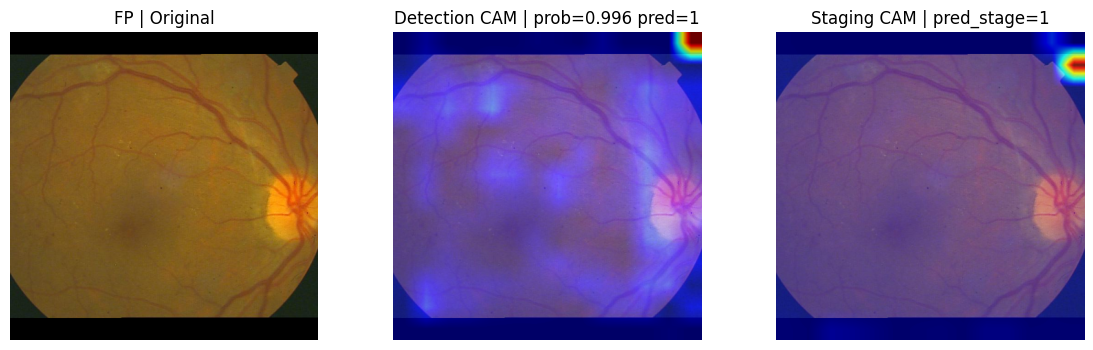

/content/drive/MyDrive/papilloedema/N/IM000352.JPG


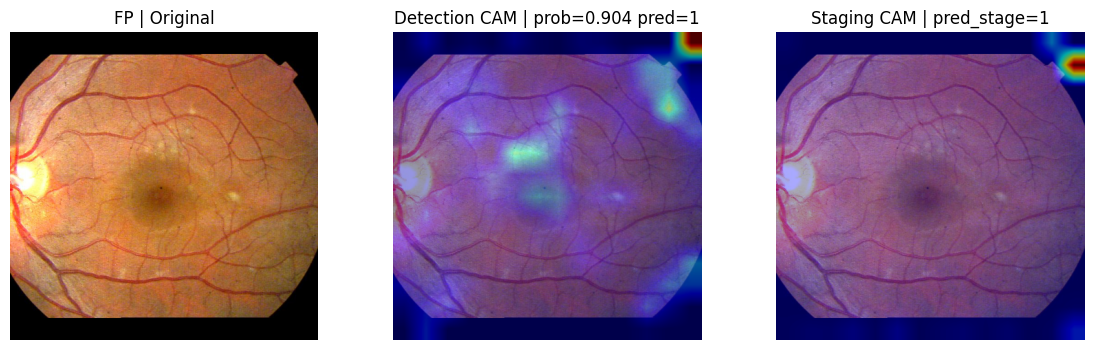

/content/drive/MyDrive/papilloedema/N/IM000508.JPG


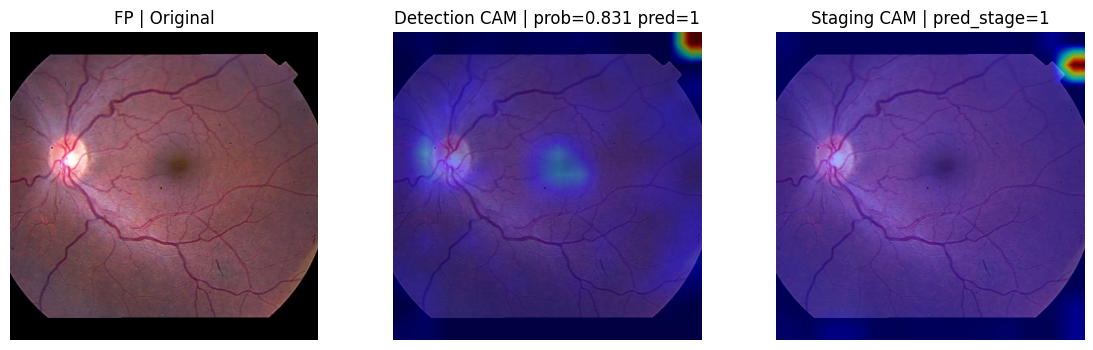

=== Showing Biggest Staging Grade-Jump Errors ===
True=2 Pred=5.0 | abs_err=3.0 | /content/drive/MyDrive/papilloedema/G2/IM002097.JPG


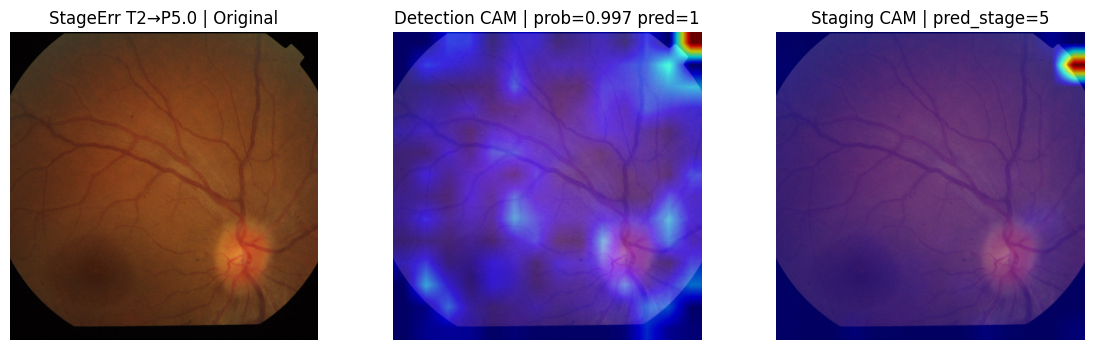

True=2 Pred=1.0 | abs_err=1.0 | /content/drive/MyDrive/papilloedema/G2/IM000641.JPG


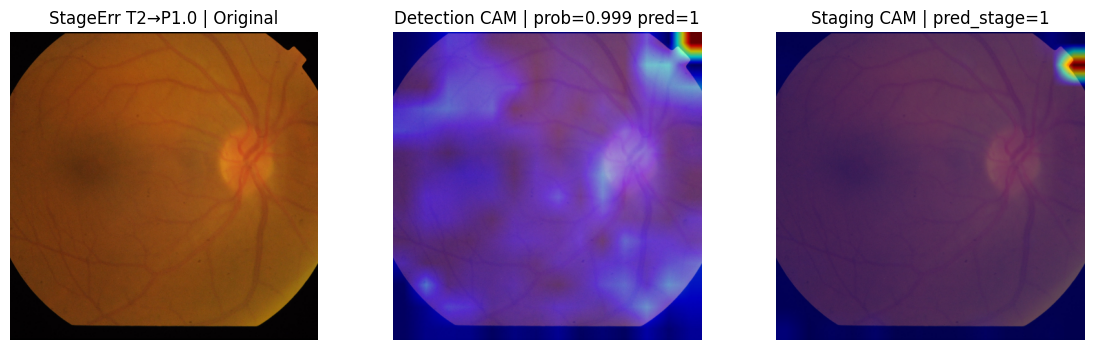

True=1 Pred=2.0 | abs_err=1.0 | /content/drive/MyDrive/papilloedema/G1/IM001692.JPG


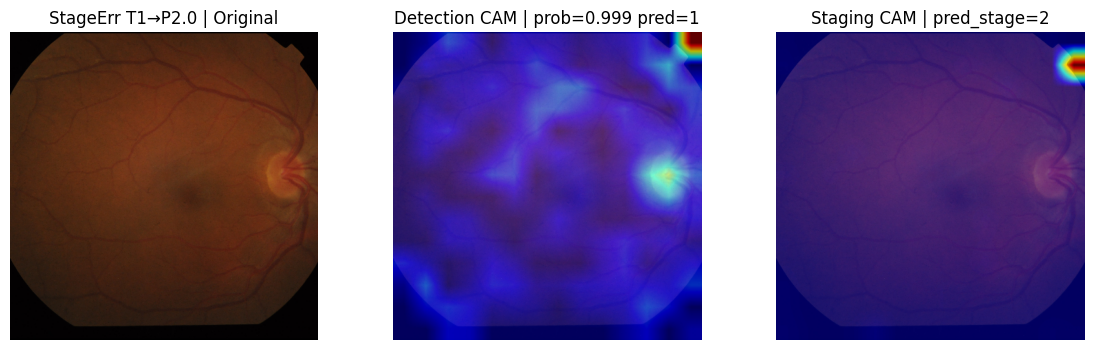

True=4 Pred=5.0 | abs_err=1.0 | /content/drive/MyDrive/papilloedema/G4/IM001066.JPG


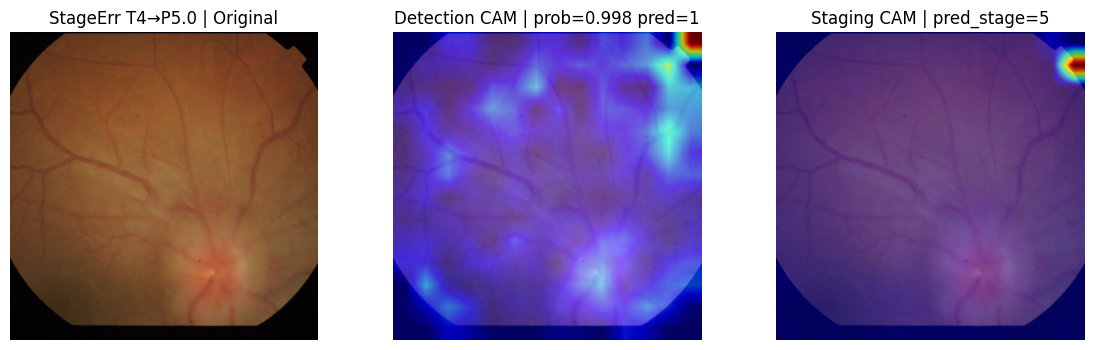

True=1 Pred=2.0 | abs_err=1.0 | /content/drive/MyDrive/papilloedema/G1/IM000095.JPG


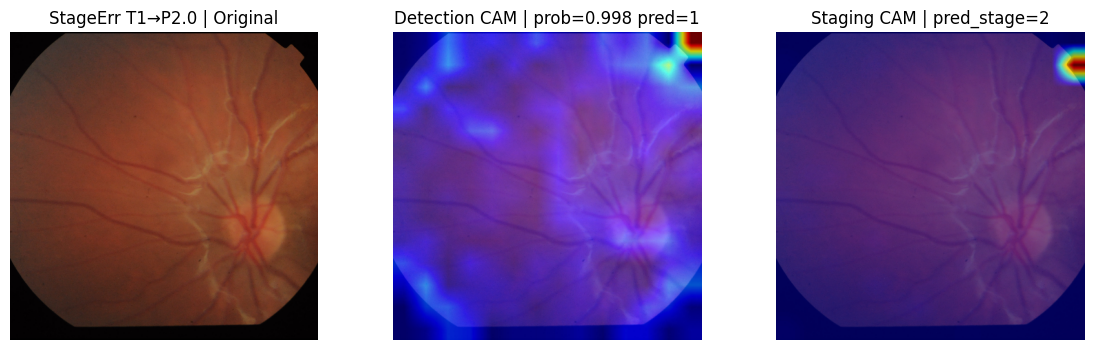

True=3 Pred=2.0 | abs_err=1.0 | /content/drive/MyDrive/papilloedema/G3/IM001975.JPG


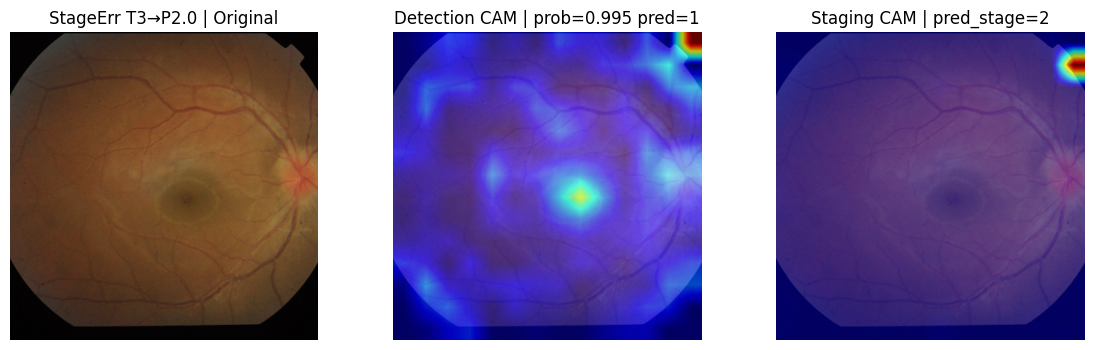

True=1 Pred=2.0 | abs_err=1.0 | /content/drive/MyDrive/papilloedema/G1/IM001693.JPG


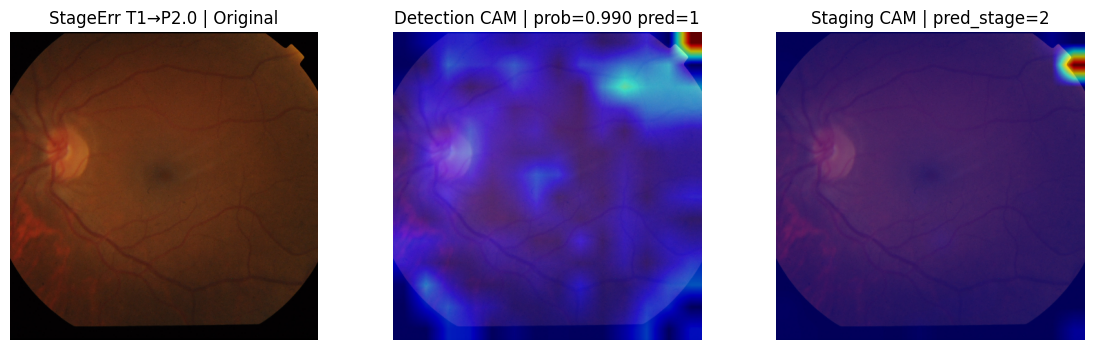

In [ ]:
print("=== Showing Detection False Positives (sorted by det_prob) ===")
for i, row in fp.head(10).iterrows():
    print(row["path"])
    show_gradcam_case(row["path"], title_prefix="FP | ")

print("=== Showing Biggest Staging Grade-Jump Errors ===")
for i, row in stage_err.head(10).iterrows():
    print(f"True={row['true_stage']} Pred={row['pred_stage']} | abs_err={row['abs_err']} | {row['path']}")
    show_gradcam_case(row["path"], title_prefix=f"StageErr T{row['true_stage']}→P{row['pred_stage']} | ")


In [ ]:
import numpy as np
from sklearn.metrics import recall_score, confusion_matrix

# get val probs
y_true_val, _, y_prob_val = get_detection_preds(det_model, val_loader, threshold=0.5)

best_thr = 0.5
best_spec = -1

for thr in np.linspace(0.1, 0.99, 90):
    y_pred = (y_prob_val >= thr).astype(int)
    rec = recall_score(y_true_val, y_pred)
    if rec < 1.0:
        continue
    tn, fp, fn, tp = confusion_matrix(y_true_val, y_pred).ravel()
    spec = tn / (tn + fp + 1e-9)
    if spec > best_spec:
        best_spec = spec
        best_thr = thr

print("✅ Best threshold with Recall=1.0 on VAL:", best_thr, "Specificity:", best_spec)


✅ Best threshold with Recall=1.0 on VAL: 0.21000000000000002 Specificity: 0.9583333333133681


In [ ]:
import numpy as np
from sklearn.metrics import recall_score, confusion_matrix

y_true_val, _, y_prob_val = get_detection_preds(det_model, val_loader, threshold=0.5)

best_thr = None
best_spec = None

for thr in np.linspace(0.99, 0.01, 99):   # search HIGH to LOW
    y_pred = (y_prob_val >= thr).astype(int)
    rec = recall_score(y_true_val, y_pred)
    if rec == 1.0:
        tn, fp, fn, tp = confusion_matrix(y_true_val, y_pred).ravel()
        spec = tn / (tn + fp + 1e-9)
        best_thr = float(thr)
        best_spec = float(spec)
        break

print("✅ Max threshold with Recall=1.0 on VAL:", best_thr, "Specificity:", best_spec)


✅ Max threshold with Recall=1.0 on VAL: 0.83 Specificity: 0.9583333333133681


In [ ]:
eval_detection(det_model, test_loader, threshold=best_thr)


=== Detection (TEST) ===
AUC: 0.986
Recall (Sensitivity): 0.9737
Specificity: 0.9388

Classification Report:
                 precision    recall  f1-score   support

Non-papilledema     0.9787    0.9388    0.9583        49
    Papilledema     0.9250    0.9737    0.9487        38

       accuracy                         0.9540        87
      macro avg     0.9519    0.9562    0.9535        87
   weighted avg     0.9553    0.9540    0.9541        87

Confusion Matrix [tn fp; fn tp]:
 [[46  3]
 [ 1 37]]


In [ ]:
import cv2
import numpy as np

def crop_to_fundus(img_rgb, pad=8):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    mask = gray > 10  # remove black border
    if mask.sum() < 1000:
        return img_rgb
    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()
    y0 = max(0, y0 - pad); x0 = max(0, x0 - pad)
    y1 = min(img_rgb.shape[0]-1, y1 + pad); x1 = min(img_rgb.shape[1]-1, x1 + pad)
    return img_rgb[y0:y1+1, x0:x1+1]


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform2 = A.Compose([
    A.Resize(448, 448),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.CLAHE(p=0.3),
    A.GaussianBlur(blur_limit=3, p=0.2),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

val_transform2 = A.Compose([
    A.Resize(448, 448),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])


In [ ]:
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = crop_to_fundus(image)   # ✅ important


NameError: name 'img_path' is not defined

In [ ]:
import cv2
import torch
from torch.utils.data import Dataset

class PapilledemaDatasetCrop(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["path"]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = crop_to_fundus(image)  # ✅ crop black borders

        if self.transform:
            image = self.transform(image=image)["image"]

        detect = torch.tensor(row["detect"], dtype=torch.float32)
        stage  = torch.tensor(row["stage"], dtype=torch.long)

        return image, detect, stage


In [ ]:
from torch.utils.data import DataLoader

train_ds2 = PapilledemaDatasetCrop(train_df, train_transform2)
val_ds2   = PapilledemaDatasetCrop(val_df, val_transform2)
test_ds2  = PapilledemaDatasetCrop(test_df, val_transform2)

train_loader2 = DataLoader(train_ds2, batch_size=8, shuffle=True, num_workers=2)
val_loader2   = DataLoader(val_ds2, batch_size=8, shuffle=False, num_workers=2)
test_loader2  = DataLoader(test_ds2, batch_size=8, shuffle=False, num_workers=2)

# sanity check one batch
images, detect, stage = next(iter(train_loader2))
print(images.shape, detect[:5], stage[:5])


torch.Size([8, 3, 448, 448]) tensor([1., 1., 1., 1., 1.]) tensor([3, 1, 1, 1, 1])


In [ ]:
model2 = DetectionModel().cuda()
optimizer2 = optim.AdamW(model2.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode="max", factor=0.5, patience=2)
criterion2 = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

best_auc2 = 0
for epoch in range(10):
    train_loss = train_one_epoch(model2, train_loader2, optimizer2, criterion2)
    val_loss, val_auc, val_recall = validate(model2, val_loader2, criterion2)
    scheduler2.step(val_auc)
    print(f"Epoch {epoch+1}/10 | TrainLoss {train_loss:.4f} | ValAUC {val_auc:.4f} | ValRecall {val_recall:.4f}")

    if val_auc > best_auc2:
        best_auc2 = val_auc
        torch.save(model2.state_dict(), "/content/drive/MyDrive/best_detection_model_funduscrop.pth")
        print("✅ Saved improved detection model")


Epoch 1/10 | TrainLoss 0.6971 | ValAUC 0.8547 | ValRecall 0.8462
✅ Saved improved detection model
Epoch 2/10 | TrainLoss 0.5215 | ValAUC 0.9589 | ValRecall 0.8974
✅ Saved improved detection model
Epoch 3/10 | TrainLoss 0.4961 | ValAUC 0.9423 | ValRecall 0.8974
Epoch 4/10 | TrainLoss 0.3808 | ValAUC 0.9666 | ValRecall 1.0000
✅ Saved improved detection model
Epoch 5/10 | TrainLoss 0.3974 | ValAUC 0.9471 | ValRecall 0.9487
Epoch 6/10 | TrainLoss 0.3276 | ValAUC 0.9493 | ValRecall 1.0000
Epoch 7/10 | TrainLoss 0.3448 | ValAUC 0.9682 | ValRecall 1.0000
✅ Saved improved detection model
Epoch 8/10 | TrainLoss 0.3243 | ValAUC 0.9533 | ValRecall 1.0000
Epoch 9/10 | TrainLoss 0.3133 | ValAUC 0.9498 | ValRecall 0.9744
Epoch 10/10 | TrainLoss 0.3426 | ValAUC 0.9407 | ValRecall 1.0000


In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/best_detection_model_funduscrop.pth"))
eval_detection(model2, test_loader2, threshold=0.5)


=== Detection (TEST) ===
AUC: 0.9737
Recall (Sensitivity): 1.0
Specificity: 0.9388

Classification Report:
                 precision    recall  f1-score   support

Non-papilledema     1.0000    0.9388    0.9684        49
    Papilledema     0.9268    1.0000    0.9620        38

       accuracy                         0.9655        87
      macro avg     0.9634    0.9694    0.9652        87
   weighted avg     0.9680    0.9655    0.9656        87

Confusion Matrix [tn fp; fn tp]:
 [[46  3]
 [ 0 38]]


In [ ]:
def make_det3_label(row):
    # 0 = Normal (N)
    # 1 = Pseudopapilledema
    # 2 = Papilledema (G1..G5)
    p = row["path"]
    if "/N/" in p or "\\N\\" in p:
        return 0
    if "Pseudopapilledema" in p:
        return 1
    return 2

train_df3 = train_df.copy()
val_df3 = val_df.copy()
test_df3 = test_df.copy()

train_df3["det3"] = train_df3.apply(make_det3_label, axis=1)
val_df3["det3"] = val_df3.apply(make_det3_label, axis=1)
test_df3["det3"] = test_df3.apply(make_det3_label, axis=1)

print(train_df3["det3"].value_counts())
print(val_df3["det3"].value_counts())
print(test_df3["det3"].value_counts())


det3
1    206
2    180
0     20
Name: count, dtype: int64
det3
1    43
2    39
0     5
Name: count, dtype: int64
det3
1    46
2    38
0     3
Name: count, dtype: int64


In [ ]:
class Det3DatasetCrop(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["path"]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = crop_to_fundus(image)

        if self.transform:
            image = self.transform(image=image)["image"]

        y = torch.tensor(int(row["det3"]), dtype=torch.long)
        return image, y


In [ ]:
train_det3 = Det3DatasetCrop(train_df3, train_transform2)
val_det3   = Det3DatasetCrop(val_df3, val_transform2)
test_det3  = Det3DatasetCrop(test_df3, val_transform2)

train_det3_loader = DataLoader(train_det3, batch_size=8, shuffle=True, num_workers=2)
val_det3_loader   = DataLoader(val_det3, batch_size=8, shuffle=False, num_workers=2)
test_det3_loader  = DataLoader(test_det3, batch_size=8, shuffle=False, num_workers=2)


In [ ]:
class Det3Model(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.backbone = timm.create_model("efficientnet_b4", pretrained=True, num_classes=0)
        self.head = nn.Sequential(
            nn.Linear(self.backbone.num_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        feat = self.backbone(x)
        return self.head(feat)

det3_model = Det3Model().cuda()


In [ ]:
import numpy as np
import torch.nn as nn
import torch.optim as optim

counts = train_df3["det3"].value_counts().sort_index().values  # [N, Pseudo, Pap]
weights = 1.0 / counts
weights = weights / weights.sum() * 3  # normalize
class_weights = torch.tensor(weights, dtype=torch.float32).cuda()
print("Class weights:", class_weights)

criterion3 = nn.CrossEntropyLoss(weight=class_weights)
optimizer3 = optim.AdamW(det3_model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler3 = optim.lr_scheduler.ReduceLROnPlateau(optimizer3, mode="max", factor=0.5, patience=2)


Class weights: tensor([2.4830, 0.2411, 0.2759], device='cuda:0')


In [ ]:
from sklearn.metrics import recall_score, confusion_matrix

def train_one_epoch_det3(model, loader, optimizer, criterion):
    model.train()
    total = 0.0
    for x, y in loader:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total += loss.item()
    return total / len(loader)

@torch.no_grad()
def eval_det3_as_binary(model, loader):
    # Treat class 2 as "papilledema", classes 0/1 as "non"
    model.eval()
    y_true_bin, y_pred_bin = [], []
    for x, y in loader:
        x = x.cuda()
        logits = model(x)
        pred = logits.argmax(dim=1).cpu().numpy()

        true_bin = (y.numpy() == 2).astype(int)
        pred_bin = (pred == 2).astype(int)

        y_true_bin.extend(true_bin.tolist())
        y_pred_bin.extend(pred_bin.tolist())

    y_true_bin = np.array(y_true_bin)
    y_pred_bin = np.array(y_pred_bin)

    tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin).ravel()
    rec = tp / (tp + fn + 1e-9)
    spec = tn / (tn + fp + 1e-9)
    return rec, spec, (tn, fp, fn, tp)

best_score = -1
for epoch in range(10):
    tr_loss = train_one_epoch_det3(det3_model, train_det3_loader, optimizer3, criterion3)
    val_rec, val_spec, cm = eval_det3_as_binary(det3_model, val_det3_loader)
    score = val_rec + val_spec  # simple combined objective
    scheduler3.step(score)
    print(f"Epoch {epoch+1}/10 | TrainLoss {tr_loss:.4f} | ValRecall {val_rec:.4f} | ValSpec {val_spec:.4f} | cm {cm}")

    if score > best_score:
        best_score = score
        torch.save(det3_model.state_dict(), "/content/drive/MyDrive/best_det3_model.pth")
        print("✅ Saved best 3-class detector")


Epoch 1/10 | TrainLoss 0.5459 | ValRecall 0.9744 | ValSpec 0.8958 | cm (np.int64(43), np.int64(5), np.int64(1), np.int64(38))
✅ Saved best 3-class detector
Epoch 2/10 | TrainLoss 0.3123 | ValRecall 0.8718 | ValSpec 0.9792 | cm (np.int64(47), np.int64(1), np.int64(5), np.int64(34))
Epoch 3/10 | TrainLoss 0.2003 | ValRecall 0.9744 | ValSpec 0.9167 | cm (np.int64(44), np.int64(4), np.int64(1), np.int64(38))
✅ Saved best 3-class detector
Epoch 4/10 | TrainLoss 0.1838 | ValRecall 0.9744 | ValSpec 0.9583 | cm (np.int64(46), np.int64(2), np.int64(1), np.int64(38))
✅ Saved best 3-class detector
Epoch 5/10 | TrainLoss 0.1985 | ValRecall 0.9231 | ValSpec 0.9583 | cm (np.int64(46), np.int64(2), np.int64(3), np.int64(36))
Epoch 6/10 | TrainLoss 0.1161 | ValRecall 1.0000 | ValSpec 0.9375 | cm (np.int64(45), np.int64(3), np.int64(0), np.int64(39))
✅ Saved best 3-class detector
Epoch 7/10 | TrainLoss 0.1204 | ValRecall 0.9487 | ValSpec 0.9583 | cm (np.int64(46), np.int64(2), np.int64(2), np.int64(37)

In [ ]:
det3_model.load_state_dict(torch.load("/content/drive/MyDrive/best_det3_model.pth"))
test_rec, test_spec, cm = eval_det3_as_binary(det3_model, test_det3_loader)
print("=== 3-class detector collapsed to binary (TEST) ===")
print("Recall:", round(test_rec,4), "Specificity:", round(test_spec,4), "cm:", cm)


=== 3-class detector collapsed to binary (TEST) ===
Recall: 0.9211 Specificity: 0.9592 cm: (np.int64(47), np.int64(2), np.int64(3), np.int64(35))


In [ ]:
# Use your original best binary detector (FN=0) and original val_loader_path or build one
val_ds_path = PapilledemaDatasetWithPath(val_df, val_model_transform)
val_loader_path = DataLoader(val_ds_path, batch_size=8, shuffle=False, num_workers=2)

det_results_val = infer_detection(det_model, val_loader_path, threshold=0.5)
fp_val = det_results_val[(det_results_val.true_detect == 0) & (det_results_val.pred_detect == 1)].copy()
fp_val = fp_val.sort_values("det_prob", ascending=False)

print("VAL false positives:", len(fp_val))
display(fp_val[["det_prob","path"]].head(20))


VAL false positives: 2


det_prob                                               path
83  0.970798  /content/drive/MyDrive/papilloedema/N/IM001605...
57  0.901247  /content/drive/MyDrive/papilloedema/N/IM001011...

In [ ]:
from torch.utils.data import WeightedRandomSampler

# Mark hard negatives
hard_set = set(fp_val["path"].tolist())

train_df_hnm = train_df.copy()
train_df_hnm["is_hardneg"] = train_df_hnm["path"].apply(lambda p: 1 if p in hard_set else 0)

# weights: boost hard negatives strongly, mild boost for positives to keep recall high
weights = np.ones(len(train_df_hnm), dtype=np.float32)
weights[train_df_hnm["detect"].values == 1] *= 1.5      # keep pap seen often
weights[train_df_hnm["is_hardneg"].values == 1] *= 8.0  # hard neg mining

sampler = WeightedRandomSampler(weights, num_samples=len(train_df_hnm), replacement=True)


In [ ]:
train_ds_hnm = PapilledemaDatasetCrop(train_df_hnm, train_transform2)  # crop+resize OK
train_loader_hnm = DataLoader(train_ds_hnm, batch_size=8, sampler=sampler, num_workers=2)

# val/test loaders (no sampler)
val_ds_hnm = PapilledemaDatasetCrop(val_df, val_transform2)
test_ds_hnm = PapilledemaDatasetCrop(test_df, val_transform2)

val_loader_hnm = DataLoader(val_ds_hnm, batch_size=8, shuffle=False, num_workers=2)
test_loader_hnm = DataLoader(test_ds_hnm, batch_size=8, shuffle=False, num_workers=2)


In [ ]:
model_hnm = DetectionModel().cuda()
model_hnm.load_state_dict(torch.load("/content/drive/MyDrive/best_detection_model.pth"))  # start from your best

optimizer_hnm = optim.AdamW(model_hnm.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler_hnm = optim.lr_scheduler.ReduceLROnPlateau(optimizer_hnm, mode="max", factor=0.5, patience=1)
criterion_hnm = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

best_auc = 0
for epoch in range(5):
    tr_loss = train_one_epoch(model_hnm, train_loader_hnm, optimizer_hnm, criterion_hnm)
    val_loss, val_auc, val_recall = validate(model_hnm, val_loader_hnm, criterion_hnm)
    scheduler_hnm.step(val_auc)

    print(f"Epoch {epoch+1}/5 | TrainLoss {tr_loss:.4f} | ValAUC {val_auc:.4f} | ValRecall {val_recall:.4f}")

    # Keep the model that maintains recall=1.0 and improves AUC
    if val_recall == 1.0 and val_auc >= best_auc:
        best_auc = val_auc
        torch.save(model_hnm.state_dict(), "/content/drive/MyDrive/best_detection_model_hnm.pth")
        print("✅ Saved HNM detector")


Epoch 1/5 | TrainLoss 0.1096 | ValAUC 0.9813 | ValRecall 1.0000
✅ Saved HNM detector
Epoch 2/5 | TrainLoss 0.0445 | ValAUC 0.9845 | ValRecall 1.0000
✅ Saved HNM detector
Epoch 3/5 | TrainLoss 0.0889 | ValAUC 0.9834 | ValRecall 1.0000
Epoch 4/5 | TrainLoss 0.0509 | ValAUC 0.9840 | ValRecall 1.0000
Epoch 5/5 | TrainLoss 0.0708 | ValAUC 0.9808 | ValRecall 1.0000


In [ ]:
model_hnm.load_state_dict(torch.load("/content/drive/MyDrive/best_detection_model_hnm.pth"))
eval_detection(model_hnm, test_loader_hnm, threshold=0.5)


=== Detection (TEST) ===
AUC: 0.9893
Recall (Sensitivity): 1.0
Specificity: 0.9592

Classification Report:
                 precision    recall  f1-score   support

Non-papilledema     1.0000    0.9592    0.9792        49
    Papilledema     0.9500    1.0000    0.9744        38

       accuracy                         0.9770        87
      macro avg     0.9750    0.9796    0.9768        87
   weighted avg     0.9782    0.9770    0.9771        87

Confusion Matrix [tn fp; fn tp]:
 [[47  2]
 [ 0 38]]


In [ ]:
# Load improved detector
det_model_hnm = DetectionModel().cuda()
det_model_hnm.load_state_dict(torch.load("/content/drive/MyDrive/best_detection_model_hnm.pth"))
det_model_hnm.eval()

# Staging stays the same
stage_model.eval()
print("✅ Loaded HNM detector + staging model")


✅ Loaded HNM detector + staging model


In [ ]:
y_true_7, y_pred_7 = hybrid_predict(det_model_hnm, stage_model, test_loader, det_threshold=0.5)

print("=== Hybrid 7-class report (TEST) using HNM detector ===")
print(classification_report(
    y_true_7, y_pred_7,
    labels=[0,1,2,3,4,5],
    target_names=["Non-papilledema","G1","G2","G3","G4","G5"],
    digits=4,
    zero_division=0
))

print("Confusion Matrix (7-class):")
print(confusion_matrix(y_true_7, y_pred_7, labels=[0,1,2,3,4,5]))


=== Hybrid 7-class report (TEST) using HNM detector ===
                 precision    recall  f1-score   support

Non-papilledema     1.0000    0.9388    0.9684        49
             G1     0.8571    0.8889    0.8727        27
             G2     0.5000    0.6667    0.5714         6
             G3     1.0000    0.7500    0.8571         4
             G4     0.0000    0.0000    0.0000         1
             G5     0.0000    0.0000    0.0000         0

       accuracy                         0.8851        87
      macro avg     0.5595    0.5407    0.5450        87
   weighted avg     0.9097    0.8851    0.8951        87

Confusion Matrix (7-class):
[[46  3  0  0  0  0]
 [ 0 24  3  0  0  0]
 [ 0  1  4  0  0  1]
 [ 0  0  1  3  0  0]
 [ 0  0  0  0  0  1]
 [ 0  0  0  0  0  0]]


In [ ]:
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

class HybridDualDataset(Dataset):
    def __init__(self, df, det_transform, stage_transform):
        self.df = df.reset_index(drop=True)
        self.det_transform = det_transform
        self.stage_transform = stage_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["path"]

        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Detector sees cropped fundus (like your HNM detector training/eval)
        img_det = crop_to_fundus(img)
        x_det = self.det_transform(image=img_det)["image"]

        # Staging sees the same preprocessing it was trained on (keep as-is)
        x_stage = self.stage_transform(image=img)["image"]

        detect = torch.tensor(int(row["detect"]), dtype=torch.long)
        stage  = torch.tensor(int(row["stage"]), dtype=torch.long)

        return x_det, x_stage, detect, stage, path

hybrid_test_ds = HybridDualDataset(
    test_df,
    det_transform=val_transform2,   # detector crop+resize pipeline
    stage_transform=val_transform   # staging pipeline you trained with
)
hybrid_test_loader = DataLoader(hybrid_test_ds, batch_size=8, shuffle=False, num_workers=2)

print("✅ Hybrid dual test loader ready:", len(hybrid_test_ds))


✅ Hybrid dual test loader ready: 87


In [ ]:
@torch.no_grad()
def hybrid_predict_dual(det_model, stage_model, loader, det_threshold=0.5):
    y_true_7, y_pred_7 = [], []

    det_model.eval()
    stage_model.eval()

    for x_det, x_stage, detect, stage, path in loader:
        x_det = x_det.cuda()
        x_stage = x_stage.cuda()

        # true 7-class
        detect_np = detect.numpy().astype(int)
        stage_np = stage.numpy().astype(int)
        true7 = [0 if d == 0 else s for d, s in zip(detect_np, stage_np)]
        y_true_7.extend(true7)

        # detect
        det_logits = det_model(x_det)
        det_probs = torch.sigmoid(det_logits)
        det_pred = (det_probs >= det_threshold).long().cpu().numpy()

        # stage (only for predicted positives)
        stage_logits = stage_model(x_stage)
        stage_pred = coral_decode(stage_logits).cpu().numpy()

        pred7 = []
        for i in range(len(det_pred)):
            pred7.append(0 if det_pred[i] == 0 else int(stage_pred[i]))
        y_pred_7.extend(pred7)

    return np.array(y_true_7), np.array(y_pred_7)

y_true_7, y_pred_7 = hybrid_predict_dual(det_model_hnm, stage_model, hybrid_test_loader, det_threshold=0.5)

print("=== Hybrid 7-class report (TEST) using HNM detector (consistent preprocessing) ===")
print(classification_report(
    y_true_7, y_pred_7,
    labels=[0,1,2,3,4,5],
    target_names=["Non-papilledema","G1","G2","G3","G4","G5"],
    digits=4,
    zero_division=0
))

print("Confusion Matrix (7-class):")
print(confusion_matrix(y_true_7, y_pred_7, labels=[0,1,2,3,4,5]))


=== Hybrid 7-class report (TEST) using HNM detector (consistent preprocessing) ===
                 precision    recall  f1-score   support

Non-papilledema     1.0000    0.9592    0.9792        49
             G1     0.8889    0.8889    0.8889        27
             G2     0.5000    0.6667    0.5714         6
             G3     1.0000    0.7500    0.8571         4
             G4     0.0000    0.0000    0.0000         1
             G5     0.0000    0.0000    0.0000         0

       accuracy                         0.8966        87
      macro avg     0.5648    0.5441    0.5494        87
   weighted avg     0.9195    0.8966    0.9062        87

Confusion Matrix (7-class):
[[47  2  0  0  0  0]
 [ 0 24  3  0  0  0]
 [ 0  1  4  0  0  1]
 [ 0  0  1  3  0  0]
 [ 0  0  0  0  0  1]
 [ 0  0  0  0  0  0]]


In [ ]:
# Build stage val positives loader with paths (using the same stage preprocessing used in training)
stage_val_df_pos = val_df[val_df.detect == 1].reset_index(drop=True)

stage_val_ds_path = PapilledemaDatasetWithPath(stage_val_df_pos, val_model_transform)  # returns x, detect, stage, path
stage_val_loader_path = DataLoader(stage_val_ds_path, batch_size=8, shuffle=False, num_workers=2)

# Infer staging on VAL positives
stage_val_results = infer_staging(stage_model, stage_val_loader_path)  # uses coral_decode
stage_val_results["abs_err"] = (stage_val_results["true_stage"] - stage_val_results["pred_stage"]).abs()

hard_stage = stage_val_results[stage_val_results["abs_err"] >= 2].sort_values("abs_err", ascending=False)
med_stage  = stage_val_results[stage_val_results["abs_err"] == 1]

print("VAL staging errors (abs_err>=2):", len(hard_stage))
display(hard_stage.head(20))

print("\nVAL staging errors (abs_err==1):", len(med_stage))
display(med_stage.head(20))


VAL staging errors (abs_err>=2): 0


Empty DataFrame
Columns: [path, true_stage, pred_stage, abs_err]
Index: []


VAL staging errors (abs_err==1): 12


path  true_stage  pred_stage  \
0   /content/drive/MyDrive/papilloedema/G4/IM00107...           4           5   
2   /content/drive/MyDrive/papilloedema/G2/IM00091...           2           1   
4   /content/drive/MyDrive/papilloedema/G4/IM00197...           4           5   
9   /content/drive/MyDrive/papilloedema/G2/IM00156...           2           1   
14  /content/drive/MyDrive/papilloedema/G4/IM00197...           4           5   
16  /content/drive/MyDrive/papilloedema/G1/IM00072...           1           2   
27  /content/drive/MyDrive/papilloedema/G4/IM01492...           4           3   
28  /content/drive/MyDrive/papilloedema/G2/IM00091...           2           1   
31  /content/drive/MyDrive/papilloedema/G4/IM00106...           4           5   
33       /content/drive/MyDrive/papilloedema/G4/3.tif           4           5   
35  /content/drive/MyDrive/papilloedema/G4/IM00197...           4           5   
37  /content/drive/MyDrive/papilloedema/G2/IM00087...           2           3   

    abs_err  
0         1  
2         1  
4         1  
9         1  
14        1  
16        1  
27        1  
28        1  
31        1  
33        1  
35        1  
37        1

In [ ]:
from torch.utils.data import WeightedRandomSampler

hard_paths = set(hard_stage["path"].tolist())
med_paths  = set(med_stage["path"].tolist())

stage_train_df_hnm = stage_train_df.copy()
stage_train_df_hnm["w"] = 1.0
stage_train_df_hnm.loc[stage_train_df_hnm["path"].isin(med_paths), "w"] = 4.0
stage_train_df_hnm.loc[stage_train_df_hnm["path"].isin(hard_paths), "w"] = 8.0

weights = stage_train_df_hnm["w"].values.astype(np.float32)
sampler_stage = WeightedRandomSampler(weights, num_samples=len(stage_train_df_hnm), replacement=True)


In [ ]:
stage_train_ds_hnm = PapilledemaStageDataset(stage_train_df_hnm, train_transform)  # same as before
stage_train_loader_hnm = DataLoader(stage_train_ds_hnm, batch_size=8, sampler=sampler_stage, num_workers=2)

stage_val_ds2 = PapilledemaStageDataset(stage_val_df, val_transform)
stage_val_loader2 = DataLoader(stage_val_ds2, batch_size=8, shuffle=False, num_workers=2)


In [ ]:
stage_model_hnm = StagingModel().cuda()
stage_model_hnm.load_state_dict(torch.load("/content/drive/MyDrive/best_staging_model_coral.pth"))
stage_model_hnm.train()

optimizer_s = optim.AdamW(stage_model_hnm.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler_s = optim.lr_scheduler.ReduceLROnPlateau(optimizer_s, mode="max", factor=0.5, patience=1)

best_qwk = -1
save_path = "/content/drive/MyDrive/best_staging_model_coral_hnm.pth"

for epoch in range(5):
    tr_loss = train_one_epoch_stage(stage_model_hnm, stage_train_loader_hnm, optimizer_s, criterion_stage)
    val_loss, val_mae, val_qwk, val_acc = validate_stage(stage_model_hnm, stage_val_loader2, criterion_stage)
    scheduler_s.step(val_qwk)

    print(f"Epoch {epoch+1}/5 | TrainLoss {tr_loss:.4f} | ValQWK {val_qwk:.4f} | ValMAE {val_mae:.4f} | ValAcc {val_acc:.4f}")

    if val_qwk > best_qwk:
        best_qwk = val_qwk
        torch.save(stage_model_hnm.state_dict(), save_path)
        print("✅ Saved staging HNM model")


Epoch 1/5 | TrainLoss 0.3917 | ValQWK 0.9111 | ValMAE 0.3077 | ValAcc 0.6923
✅ Saved staging HNM model
Epoch 2/5 | TrainLoss 0.1502 | ValQWK 0.9032 | ValMAE 0.3333 | ValAcc 0.6667
Epoch 3/5 | TrainLoss 0.1861 | ValQWK 0.9189 | ValMAE 0.2821 | ValAcc 0.7179
✅ Saved staging HNM model
Epoch 4/5 | TrainLoss 0.1801 | ValQWK 0.9069 | ValMAE 0.3077 | ValAcc 0.6923
Epoch 5/5 | TrainLoss 0.1711 | ValQWK 0.9232 | ValMAE 0.2564 | ValAcc 0.7436
✅ Saved staging HNM model


In [ ]:
stage_model_hnm.load_state_dict(torch.load("/content/drive/MyDrive/best_staging_model_coral_hnm.pth"))
stage_model_hnm.eval()

y_true_7, y_pred_7 = hybrid_predict_dual(det_model_hnm, stage_model_hnm, hybrid_test_loader, det_threshold=0.5)

print("=== Hybrid 7-class report (TEST) with HNM detector + HNM staging ===")
print(classification_report(
    y_true_7, y_pred_7,
    labels=[0,1,2,3,4,5],
    target_names=["Non-papilledema","G1","G2","G3","G4","G5"],
    digits=4,
    zero_division=0
))
print("Confusion Matrix (7-class):")
print(confusion_matrix(y_true_7, y_pred_7, labels=[0,1,2,3,4,5]))


=== Hybrid 7-class report (TEST) with HNM detector + HNM staging ===
                 precision    recall  f1-score   support

Non-papilledema     1.0000    0.9592    0.9792        49
             G1     0.8929    0.9259    0.9091        27
             G2     0.6250    0.8333    0.7143         6
             G3     1.0000    0.7500    0.8571         4
             G4     1.0000    1.0000    1.0000         1
             G5     0.0000    0.0000    0.0000         0

       accuracy                         0.9310        87
      macro avg     0.7530    0.7447    0.7433        87
   weighted avg     0.9409    0.9310    0.9338        87

Confusion Matrix (7-class):
[[47  2  0  0  0  0]
 [ 0 25  2  0  0  0]
 [ 0  1  5  0  0  0]
 [ 0  0  1  3  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  0  0]]


In [ ]:
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score

REPORT_DIR = "/content/drive/MyDrive/papilledema_final_report"
os.makedirs(REPORT_DIR, exist_ok=True)

# Save hybrid classification report
report_txt = classification_report(
    y_true_7, y_pred_7,
    labels=[0,1,2,3,4,5],
    target_names=["Non-papilledema","G1","G2","G3","G4","G5"],
    digits=4,
    zero_division=0
)

cm7 = confusion_matrix(y_true_7, y_pred_7, labels=[0,1,2,3,4,5])

with open(f"{REPORT_DIR}/hybrid_7class_report.txt", "w") as f:
    f.write(report_txt)

np.savetxt(f"{REPORT_DIR}/hybrid_7class_confusion_matrix.csv", cm7, delimiter=",", fmt="%d")

print("✅ Saved hybrid report + confusion matrix to:", REPORT_DIR)


✅ Saved hybrid report + confusion matrix to: /content/drive/MyDrive/papilledema_final_report


In [ ]:
# staging test positives only, using the same hybrid loader predictions
mask_pos = (y_true_7 != 0)
true_stage = y_true_7[mask_pos]
pred_stage = y_pred_7[mask_pos]

mae = np.mean(np.abs(true_stage - pred_stage))
qwk = cohen_kappa_score(true_stage, pred_stage, weights="quadratic")

print("Staging TEST MAE:", round(mae, 4))
print("Staging TEST QWK:", round(qwk, 4))

with open(f"{REPORT_DIR}/staging_metrics.txt", "w") as f:
    f.write(f"Staging TEST MAE: {mae:.6f}\n")
    f.write(f"Staging TEST QWK: {qwk:.6f}\n")


Staging TEST MAE: 0.1053
Staging TEST QWK: 0.9107


In [ ]:
import os, cv2, numpy as np
import torch
import torch.nn as nn
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# ---------- Device ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ---------- Fundus crop (keep the one you used) ----------
def crop_to_fundus(img_rgb, pad=8):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    mask = gray > 10
    if mask.sum() < 1000:
        return img_rgb
    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()
    y0 = max(0, y0 - pad); x0 = max(0, x0 - pad)
    y1 = min(img_rgb.shape[0]-1, y1 + pad); x1 = min(img_rgb.shape[1]-1, x1 + pad)
    return img_rgb[y0:y1+1, x0:x1+1]

# ---------- Normalization ----------
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

# Detector transform (crop_to_fundus + resize)
det_transform = A.Compose([
    A.Resize(448, 448),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

# Staging transform (match what you used for staging evaluation)
# If your original val_transform exists, keep using it.
# Otherwise, use this default:
stage_transform = A.Compose([
    A.LongestMaxSize(max_size=512),
    A.PadIfNeeded(512, 512, border_mode=0),
    A.CenterCrop(448, 448),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

# A "visual" transform for displaying (no normalize)
vis_transform = A.Compose([
    A.LongestMaxSize(max_size=512),
    A.PadIfNeeded(512, 512, border_mode=0),
    A.CenterCrop(448, 448),
])

# ---------- Models ----------
class DetectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model("efficientnet_b4", pretrained=False, num_classes=0)
        self.head = nn.Sequential(
            nn.Linear(self.backbone.num_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        feat = self.backbone(x)
        return self.head(feat).squeeze(1)

class StagingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model("efficientnet_b4", pretrained=False, num_classes=0)
        self.head = nn.Sequential(
            nn.Linear(self.backbone.num_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 4)  # CORAL logits
        )
    def forward(self, x):
        feat = self.backbone(x)
        return self.head(feat)

def coral_decode(logits):
    probs = torch.sigmoid(logits)
    pred = 1 + (probs > 0.5).sum(dim=1)
    return pred

# ---------- Load FINAL checkpoints ----------
DET_CKPT = "/content/drive/MyDrive/best_detection_model_hnm.pth"
STAGE_CKPT = "/content/drive/MyDrive/best_staging_model_coral_hnm.pth"

det_model = DetectionModel().to(device)
det_model.load_state_dict(torch.load(DET_CKPT, map_location=device))
det_model.eval()

stage_model = StagingModel().to(device)
stage_model.load_state_dict(torch.load(STAGE_CKPT, map_location=device))
stage_model.eval()

print("✅ Loaded final detector + stager")


Device: cuda
✅ Loaded final detector + stager


In [ ]:
def predict_one_image(image_path, det_threshold=0.5, make_cam=True):
    vis_uint8, x_det, x_stage, rgb_float = preprocess_inputs(image_path)

    # ---- Detection (no grad) ----
    with torch.no_grad():
        det_logit = det_model(x_det)
        det_prob = torch.sigmoid(det_logit).item()
        det_pred = int(det_prob >= det_threshold)

    result = {
        "image_path": image_path,
        "det_threshold": float(det_threshold),
        "det_prob": float(det_prob),
        "det_pred": int(det_pred),
        "decision": None,
        "stage_pred": None,
        "cams": {}
    }

    # ---- Detection CAM needs grads ----
    if make_cam:
        det_layer = find_last_conv_module(det_model)
        det_cam = GradCAM(model=det_model, target_layers=[det_layer])
        with torch.enable_grad():
            det_model.zero_grad(set_to_none=True)
            det_map = det_cam(input_tensor=x_det, targets=[BinaryPositiveTarget()])[0]
        result["cams"]["detection"] = show_cam_on_image(rgb_float, det_map, use_rgb=True)

    # ---- If non-pap: stop ----
    if det_pred == 0:
        result["decision"] = "Non-papilledema"
        return result

    # ---- Staging (no grad) ----
    with torch.no_grad():
        stage_logits = stage_model(x_stage)
        stage_pred = int(coral_decode(stage_logits).item())

    result["stage_pred"] = stage_pred
    result["decision"] = f"Papilledema (G{stage_pred})"

    # ---- Staging CAM needs grads ----
    if make_cam:
        stage_layer = find_last_conv_module(stage_model)
        stage_cam = GradCAM(model=stage_model, target_layers=[stage_layer])
        with torch.enable_grad():
            stage_model.zero_grad(set_to_none=True)
            stage_map = stage_cam(input_tensor=x_stage, targets=[StageEvidenceTarget(stage_pred)])[0]
        result["cams"]["staging"] = show_cam_on_image(rgb_float, stage_map, use_rgb=True)

    return result


Decision: Papilledema (G1)


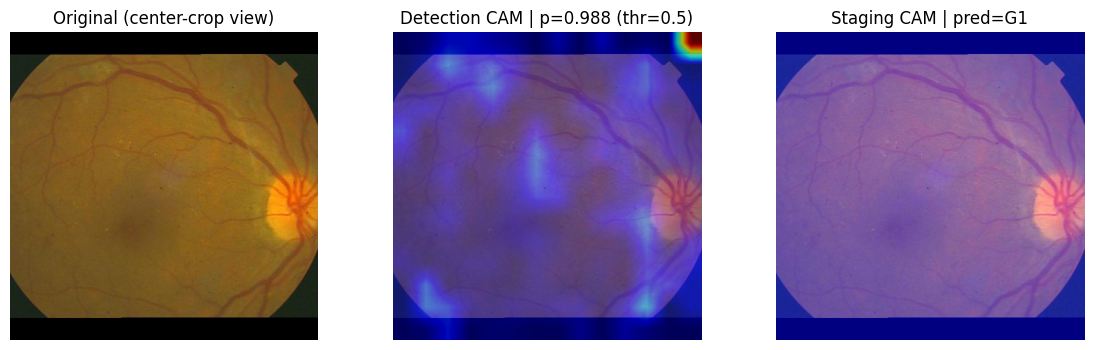

{'image_path': '/content/drive/MyDrive/papilloedema/N/IM001439.JPG',
 'det_threshold': 0.5,
 'det_prob': 0.987880289554596,
 'det_pred': 1,
 'decision': 'Papilledema (G1)',
 'stage_pred': 1,
 'cams': {'detection': array([[[ 0,  0, 90],
          [ 0,  0, 90],
          [ 0,  0, 90],
          ...,
          [93,  0,  0],
          [93,  0,  0],
          [93,  0,  0]],
  
         [[ 0,  0, 90],
          [ 0,  0, 90],
          [ 0,  0, 90],
          ...,
          [93,  0,  0],
          [93,  0,  0],
          [93,  0,  0]],
  
         [[ 0,  0, 90],
          [ 0,  0, 90],
          [ 0,  0, 90],
          ...,
          [93,  0,  0],
          [93,  0,  0],
          [93,  0,  0]],
  
         ...,
  
         [[ 0,  0, 90],
          [ 0,  0, 90],
          [ 0,  0, 90],
          ...,
          [ 0,  0, 90],
          [ 0,  0, 90],
          [ 0,  0, 90]],
  
         [[ 0,  0, 90],
          [ 0,  0, 90],
          [ 0,  0, 90],
          ...,
          [ 0,  0, 90],
        

In [ ]:
demo_path = "/content/drive/MyDrive/papilloedema/N/IM001439.JPG"
res = predict_one_image(demo_path, det_threshold=0.5, make_cam=True)
show_prediction(res)
res


In [ ]:
import cv2, numpy as np, torch
from torch.utils.data import Dataset, DataLoader

class DetectionDatasetHNM(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["path"]

        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = crop_to_fundus(img)  # IMPORTANT: same as HNM detector eval
        x = self.transform(image=img)["image"]

        y = int(row["detect"])  # 0/1
        return x, y, path

det_test_ds = DetectionDatasetHNM(test_df, val_transform2)
det_test_loader = DataLoader(det_test_ds, batch_size=16, shuffle=False, num_workers=2)

print("✅ Detection test loader ready:", len(det_test_ds))


✅ Detection test loader ready: 87


In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

det_model_hnm.eval()

y_true_det = []
y_prob_det = []
y_pred_det = []

threshold = 0.5

with torch.no_grad():
    for x, y, paths in det_test_loader:
        x = x.cuda()
        logits = det_model_hnm(x)
        probs = torch.sigmoid(logits).cpu().numpy()

        y_true_det.extend(y)
        y_prob_det.extend(probs.tolist())
        y_pred_det.extend((probs >= threshold).astype(int).tolist())

y_true_det = np.array(y_true_det).astype(int)
y_prob_det = np.array(y_prob_det).astype(float)
y_pred_det = np.array(y_pred_det).astype(int)

print("✅ Arrays created:",
      "y_true_det", y_true_det.shape,
      "y_prob_det", y_prob_det.shape,
      "y_pred_det", y_pred_det.shape)

print("AUC:", round(roc_auc_score(y_true_det, y_prob_det), 4),
      "| AP:", round(average_precision_score(y_true_det, y_prob_det), 4))


✅ Arrays created: y_true_det (87,) y_prob_det (87,) y_pred_det (87,)
AUC: 0.9893 | AP: 0.9814


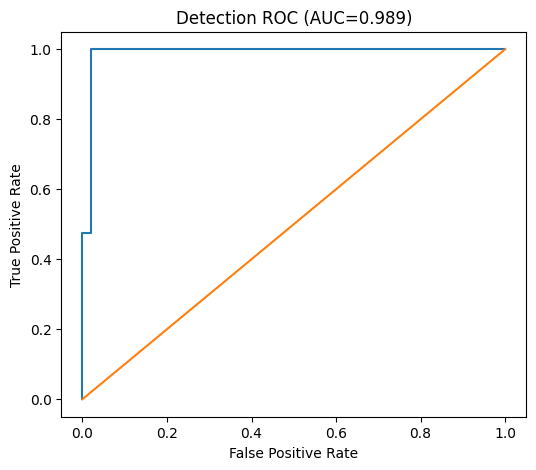

Saved: /content/drive/MyDrive/papilledema_final_report/plots/detection_ROC.png


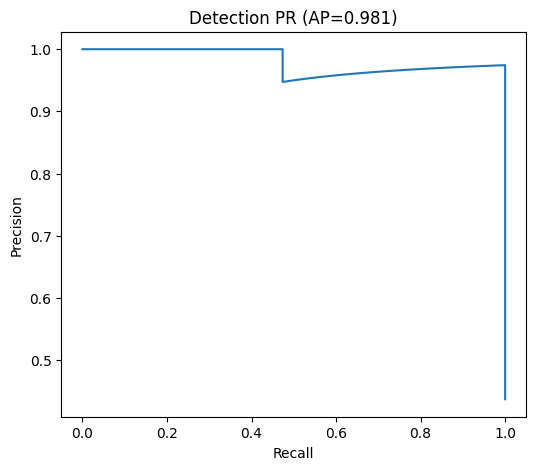

Saved: /content/drive/MyDrive/papilledema_final_report/plots/detection_PR.png


In [ ]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

OUT_DIR = "/content/drive/MyDrive/papilledema_final_report/plots"
os.makedirs(OUT_DIR, exist_ok=True)

auc = roc_auc_score(y_true_det, y_prob_det)
ap  = average_precision_score(y_true_det, y_prob_det)

# ROC
fpr, tpr, _ = roc_curve(y_true_det, y_prob_det)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Detection ROC (AUC={auc:.3f})")
roc_path = os.path.join(OUT_DIR, "detection_ROC.png")
plt.savefig(roc_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", roc_path)

# PR
prec, rec, _ = precision_recall_curve(y_true_det, y_prob_det)
plt.figure(figsize=(6,5))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Detection PR (AP={ap:.3f})")
pr_path = os.path.join(OUT_DIR, "detection_PR.png")
plt.savefig(pr_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", pr_path)


In [ ]:
!pip -q install scikit-image opencv-python tqdm xgboost

import os, cv2, numpy as np, pandas as pd
from tqdm import tqdm

from skimage.feature import local_binary_pattern
from skimage.filters import frangi
from skimage.measure import shannon_entropy

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor


In [ ]:
def crop_to_fundus(img_rgb, pad=8):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    mask = gray > 10
    if mask.sum() < 1000:
        return img_rgb
    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()
    y0 = max(0, y0 - pad); x0 = max(0, x0 - pad)
    y1 = min(img_rgb.shape[0]-1, y1 + pad); x1 = min(img_rgb.shape[1]-1, x1 + pad)
    return img_rgb[y0:y1+1, x0:x1+1]

def estimate_disc_center(img_rgb):
    """
    Heuristic: disc is often among brightest areas in red/green channel.
    Returns (cx, cy) in image coordinates.
    """
    img = img_rgb.copy()
    h, w = img.shape[:2]
    g = img[:,:,1].astype(np.float32)

    # blur & take top bright pixels
    g_blur = cv2.GaussianBlur(g, (0,0), 5)
    thresh = np.percentile(g_blur, 99.5)
    mask = (g_blur >= thresh).astype(np.uint8)

    # find largest connected bright blob
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return (w//2, h//2)

    c = max(cnts, key=cv2.contourArea)
    M = cv2.moments(c)
    if M["m00"] == 0:
        return (w//2, h//2)
    cx = int(M["m10"]/M["m00"])
    cy = int(M["m01"]/M["m00"])
    return (cx, cy)

def crop_patch(img_rgb, cx, cy, size=224):
    h, w = img_rgb.shape[:2]
    half = size//2
    x0 = max(0, cx-half); x1 = min(w, cx+half)
    y0 = max(0, cy-half); y1 = min(h, cy+half)
    patch = img_rgb[y0:y1, x0:x1]
    # pad if near borders
    patch = cv2.copyMakeBorder(
        patch,
        top=max(0, half-cy), bottom=max(0, (cy+half)-h),
        left=max(0, half-cx), right=max(0, (cx+half)-w),
        borderType=cv2.BORDER_REFLECT_101
    )
    return patch


In [ ]:
def lbp_hist(gray, P=8, R=1):
    lbp = local_binary_pattern(gray, P, R, method="uniform")
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
    return hist

def extract_features_from_path(path):
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        return None
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    img = crop_to_fundus(img)
    cx, cy = estimate_disc_center(img)
    patch = crop_patch(img, cx, cy, size=224)  # disc-centered patch

    # Convert spaces
    patch_f = patch.astype(np.float32) / 255.0
    hsv = cv2.cvtColor((patch_f*255).astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32) / 255.0
    gray = cv2.cvtColor((patch_f*255).astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0

    feats = []

    # (1) Color: mean/std RGB + HSV
    for arr in [patch_f, hsv]:
        feats.extend(arr.reshape(-1,3).mean(axis=0).tolist())
        feats.extend(arr.reshape(-1,3).std(axis=0).tolist())

    # (2) Sharpness: gradient magnitude stats
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    grad = np.sqrt(gx*gx + gy*gy)
    feats += [grad.mean(), grad.std(), np.percentile(grad, 90)]

    # (3) LBP texture histogram
    feats.extend(lbp_hist((gray*255).astype(np.uint8), P=8, R=1).tolist())

    # (4) Vesselness (Frangi) stats
    # works on gray image; gives response to tubular structures
    v = frangi(gray)
    feats += [np.nanmean(v), np.nanstd(v), np.nanpercentile(v, 90)]

    # (5) Entropy
    feats.append(shannon_entropy((gray*255).astype(np.uint8)))

    # Optional: disc intensity “glow” (mean of center region vs outer)
    center = gray[80:144, 80:144]
    outer = np.concatenate([gray[:40,:].ravel(), gray[-40:,:].ravel(), gray[:, :40].ravel(), gray[:, -40:].ravel()])
    feats += [center.mean(), center.std(), outer.mean(), outer.std(), center.mean() - outer.mean()]

    return np.array(feats, dtype=np.float32)


In [ ]:
def build_Xy(df, task="detect"):
    X, y, bad = [], [], []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        f = extract_features_from_path(row["path"])
        if f is None:
            bad.append(row["path"])
            continue
        X.append(f)
        if task == "detect":
            y.append(int(row["detect"]))
        else:
            y.append(int(row["stage"]))
    X = np.vstack(X)
    y = np.array(y)
    return X, y, bad

# Detection features
Xtr_d, ytr_d, bad1 = build_Xy(train_df, task="detect")
Xva_d, yva_d, bad2 = build_Xy(val_df, task="detect")
Xte_d, yte_d, bad3 = build_Xy(test_df, task="detect")

print("Detection shapes:", Xtr_d.shape, Xva_d.shape, Xte_d.shape)
print("Bad images:", len(bad1)+len(bad2)+len(bad3))


100%|██████████| 87/87 [00:24<00:00,  3.59it/s]

Detection shapes: (406, 34) (87, 34) (87, 34)
Bad images: 0


In [ ]:
det_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        eval_metric="logloss",
        random_state=42
    ))
])

det_clf.fit(Xtr_d, ytr_d)

# Predict
proba = det_clf.predict_proba(Xte_d)[:,1]
pred = (proba >= 0.5).astype(int)

print("=== Classical Detection (TEST) ===")
print("AUC:", round(roc_auc_score(yte_d, proba), 4))
print(classification_report(yte_d, pred, target_names=["Non-pap","Pap"], digits=4))
print("Confusion:\n", confusion_matrix(yte_d, pred))


=== Classical Detection (TEST) ===
AUC: 0.9882
              precision    recall  f1-score   support

     Non-pap     0.9592    0.9592    0.9592        49
         Pap     0.9474    0.9474    0.9474        38

    accuracy                         0.9540        87
   macro avg     0.9533    0.9533    0.9533        87
weighted avg     0.9540    0.9540    0.9540        87

Confusion:
 [[47  2]
 [ 2 36]]


In [ ]:
# Use only papilledema positives for staging
train_pos = train_df[train_df.detect==1].reset_index(drop=True)
val_pos   = val_df[val_df.detect==1].reset_index(drop=True)
test_pos  = test_df[test_df.detect==1].reset_index(drop=True)

Xtr_s, ytr_s, _ = build_Xy(train_pos, task="stage")
Xva_s, yva_s, _ = build_Xy(val_pos, task="stage")
Xte_s, yte_s, _ = build_Xy(test_pos, task="stage")

stage_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBRegressor(
        n_estimators=800,
        max_depth=4,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42
    ))
])

stage_reg.fit(Xtr_s, ytr_s)

pred_float = stage_reg.predict(Xte_s)
pred_stage = np.clip(np.rint(pred_float), 1, 5).astype(int)

print("=== Classical Staging (TEST positives) ===")
print(classification_report(yte_s, pred_stage, digits=4))
print("Confusion:\n", confusion_matrix(yte_s, pred_stage, labels=[1,2,3,4,5]))
print("MAE:", round(np.mean(np.abs(yte_s - pred_stage)), 4))


100%|██████████| 38/38 [00:12<00:00,  2.95it/s]


=== Classical Staging (TEST positives) ===
              precision    recall  f1-score   support

           1     0.7826    0.6667    0.7200        27
           2     0.2727    0.5000    0.3529         6
           3     0.3333    0.2500    0.2857         4
           4     0.0000    0.0000    0.0000         1

    accuracy                         0.5789        38
   macro avg     0.3472    0.3542    0.3397        38
weighted avg     0.6342    0.5789    0.5974        38

Confusion:
 [[18  7  1  1  0]
 [ 3  3  0  0  0]
 [ 2  1  1  0  0]
 [ 0  0  1  0  0]
 [ 0  0  0  0  0]]
MAE: 0.5526


In [ ]:
# Hybrid prediction on full test set
# For each test sample:
#  - if detector says non-pap => 0
#  - else => staging prediction (requires staging features; we reuse same extractor)

y_true_7, y_pred_7 = [], []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    f = extract_features_from_path(row["path"])
    if f is None:
        continue

    true7 = 0 if int(row["detect"])==0 else int(row["stage"])
    y_true_7.append(true7)

    p_pap = det_clf.predict_proba(f.reshape(1,-1))[0,1]
    if p_pap < 0.5:
        y_pred_7.append(0)
    else:
        s_hat = stage_reg.predict(f.reshape(1,-1))[0]
        s_hat = int(np.clip(np.rint(s_hat), 1, 5))
        y_pred_7.append(s_hat)

y_true_7 = np.array(y_true_7)
y_pred_7 = np.array(y_pred_7)

print("=== Classical Hybrid 7-class (TEST) ===")
print(classification_report(
    y_true_7, y_pred_7,
    labels=[0,1,2,3,4,5],
    target_names=["Non-pap","G1","G2","G3","G4","G5"],
    digits=4,
    zero_division=0
))
print("Confusion:\n", confusion_matrix(y_true_7, y_pred_7, labels=[0,1,2,3,4,5]))


100%|██████████| 87/87 [00:25<00:00,  3.46it/s]

=== Classical Hybrid 7-class (TEST) ===
              precision    recall  f1-score   support

     Non-pap     0.9592    0.9592    0.9592        49
          G1     0.6957    0.5926    0.6400        27
          G2     0.2727    0.5000    0.3529         6
          G3     0.3333    0.2500    0.2857         4
          G4     0.0000    0.0000    0.0000         1
          G5     0.0000    0.0000    0.0000         0

    accuracy                         0.7701        87
   macro avg     0.3768    0.3836    0.3730        87
weighted avg     0.7903    0.7701    0.7763        87

Confusion:
 [[47  2  0  0  0  0]
 [ 2 16  7  1  1  0]
 [ 0  3  3  0  0  0]
 [ 0  2  1  1  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  0  0]]


In [ ]:
import numpy as np
from sklearn.metrics import recall_score, confusion_matrix

# probs on VAL
proba_val = det_clf.predict_proba(Xva_d)[:,1]
y_true_val = yva_d.astype(int)

best_thr = None
for thr in np.linspace(0.99, 0.01, 99):  # high->low
    pred = (proba_val >= thr).astype(int)
    if recall_score(y_true_val, pred) == 1.0:
        best_thr = float(thr)
        break

print("Best threshold with Recall=1.0 on VAL:", best_thr)

# evaluate on TEST at that threshold
proba_test = det_clf.predict_proba(Xte_d)[:,1]
pred_test = (proba_test >= best_thr).astype(int)

tn, fp, fn, tp = confusion_matrix(yte_d, pred_test).ravel()
print("TEST cm:", (tn, fp, fn, tp))
print("TEST recall:", tp/(tp+fn+1e-9), "spec:", tn/(tn+fp+1e-9))


Best threshold with Recall=1.0 on VAL: 0.6799999999999999
TEST cm: (np.int64(47), np.int64(2), np.int64(4), np.int64(34))
TEST recall: 0.8947368420817176 spec: 0.9591836734498127


In [ ]:
pos = (ytr_d == 1).sum()
neg = (ytr_d == 0).sum()
base_spw = neg / pos
print("Base scale_pos_weight:", base_spw)

det_clf2 = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(
        n_estimators=800,
        max_depth=4,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        scale_pos_weight=base_spw * 2.5,   # push recall higher
        eval_metric="logloss",
        random_state=42
    ))
])

det_clf2.fit(Xtr_d, ytr_d)

proba_test = det_clf2.predict_proba(Xte_d)[:,1]
pred_test = (proba_test >= 0.5).astype(int)

tn, fp, fn, tp = confusion_matrix(yte_d, pred_test).ravel()
print("TEST cm:", (tn, fp, fn, tp))
print("TEST recall:", tp/(tp+fn+1e-9), "spec:", tn/(tn+fp+1e-9), "AUC:", roc_auc_score(yte_d, proba_test))
print(classification_report(yte_d, pred_test, target_names=["Non-pap","Pap"], digits=4))


Base scale_pos_weight: 1.2555555555555555
TEST cm: (np.int64(47), np.int64(2), np.int64(0), np.int64(38))
TEST recall: 0.9999999999736843 spec: 0.9591836734498127 AUC: 0.9887218045112781
              precision    recall  f1-score   support

     Non-pap     1.0000    0.9592    0.9792        49
         Pap     0.9500    1.0000    0.9744        38

    accuracy                         0.9770        87
   macro avg     0.9750    0.9796    0.9768        87
weighted avg     0.9782    0.9770    0.9771        87



In [ ]:
from sklearn.calibration import CalibratedClassifierCV

# Fit uncalibrated model first
xgb_raw = XGBClassifier(
    n_estimators=800,
    max_depth=4,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    eval_metric="logloss",
    random_state=42
)
pipe_raw = Pipeline([("scaler", StandardScaler()), ("xgb", xgb_raw)])
pipe_raw.fit(Xtr_d, ytr_d)

# Calibrate on VAL
cal = CalibratedClassifierCV(pipe_raw, method="isotonic", cv="prefit")
cal.fit(Xva_d, yva_d)

proba_test = cal.predict_proba(Xte_d)[:,1]
pred_test = (proba_test >= 0.5).astype(int)

tn, fp, fn, tp = confusion_matrix(yte_d, pred_test).ravel()
print("CALIBRATED TEST cm:", (tn, fp, fn, tp))
print("Recall:", tp/(tp+fn+1e-9), "Spec:", tn/(tn+fp+1e-9), "AUC:", roc_auc_score(yte_d, proba_test))


CALIBRATED TEST cm: (np.int64(47), np.int64(2), np.int64(3), np.int64(35))
Recall: 0.9210526315547092 Spec: 0.9591836734498127 AUC: 0.9906015037593985


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [ ]:
# Use the same feature matrices you already built for staging:
# Xtr_s, ytr_s
# Xva_s, yva_s
# Xte_s, yte_s

def make_threshold_labels(y, k):
    # label = 1 if y >= k else 0
    return (y >= k).astype(int)

Ks = [2,3,4,5]
ytr_thr = {k: make_threshold_labels(ytr_s, k) for k in Ks}
yva_thr = {k: make_threshold_labels(yva_s, k) for k in Ks}
yte_thr = {k: make_threshold_labels(yte_s, k) for k in Ks}

{k: ytr_thr[k].mean() for k in Ks}


{2: np.float64(0.3277777777777778),
 3: np.float64(0.15555555555555556),
 4: np.float64(0.044444444444444446),
 5: np.float64(0.011111111111111112)}

In [ ]:
from sklearn.base import clone

thr_models = {}
base_model = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(
        n_estimators=800,
        max_depth=4,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        eval_metric="logloss",
        random_state=42
    ))
])

for k in Ks:
    m = clone(base_model)
    m.fit(Xtr_s, ytr_thr[k])
    thr_models[k] = m
    print(f"✅ trained threshold model for y>={k}")


✅ trained threshold model for y>=2
✅ trained threshold model for y>=3
✅ trained threshold model for y>=4
✅ trained threshold model for y>=5


In [ ]:
def coral_classical_predict(X):
    # count how many thresholds pass
    passes = np.zeros(X.shape[0], dtype=int)
    for k in Ks:
        p = thr_models[k].predict_proba(X)[:,1]
        passes += (p >= 0.5).astype(int)
    return 1 + passes  # 1..5

pred_stage_coral = coral_classical_predict(Xte_s)

print("=== Classical Ordinal Staging (CORAL-style) TEST positives ===")
print(classification_report(yte_s, pred_stage_coral, digits=4, zero_division=0))
print("Confusion:\n", confusion_matrix(yte_s, pred_stage_coral, labels=[1,2,3,4,5]))
print("MAE:", round(np.mean(np.abs(yte_s - pred_stage_coral)), 4))


=== Classical Ordinal Staging (CORAL-style) TEST positives ===
              precision    recall  f1-score   support

           1     0.7586    0.8148    0.7857        27
           2     0.3333    0.3333    0.3333         6
           3     0.5000    0.2500    0.3333         4
           4     0.0000    0.0000    0.0000         1

    accuracy                         0.6579        38
   macro avg     0.3980    0.3495    0.3631        38
weighted avg     0.6443    0.6579    0.6460        38

Confusion:
 [[22  4  0  1  0]
 [ 4  2  0  0  0]
 [ 3  0  1  0  0]
 [ 0  0  1  0  0]
 [ 0  0  0  0  0]]
MAE: 0.4737


In [ ]:
y_true_7, y_pred_7 = [], []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    f = extract_features_from_path(row["path"])
    if f is None:
        continue

    true7 = 0 if int(row["detect"])==0 else int(row["stage"])
    y_true_7.append(true7)

    p_pap = det_clf2.predict_proba(f.reshape(1,-1))[0,1]
    if p_pap < 0.5:
        y_pred_7.append(0)
    else:
        # staging only if predicted pap
        s_hat = coral_classical_predict(f.reshape(1,-1))[0]
        y_pred_7.append(int(s_hat))

y_true_7 = np.array(y_true_7)
y_pred_7 = np.array(y_pred_7)

print("=== Classical Hybrid 7-class (TEST) with cost-sensitive det + ordinal staging ===")
print(classification_report(
    y_true_7, y_pred_7,
    labels=[0,1,2,3,4,5],
    target_names=["Non-pap","G1","G2","G3","G4","G5"],
    digits=4,
    zero_division=0
))
print("Confusion:\n", confusion_matrix(y_true_7, y_pred_7, labels=[0,1,2,3,4,5]))


100%|██████████| 87/87 [00:25<00:00,  3.46it/s]

=== Classical Hybrid 7-class (TEST) with cost-sensitive det + ordinal staging ===
              precision    recall  f1-score   support

     Non-pap     1.0000    0.9592    0.9792        49
          G1     0.7097    0.8148    0.7586        27
          G2     0.3333    0.3333    0.3333         6
          G3     0.5000    0.2500    0.3333         4
          G4     0.0000    0.0000    0.0000         1
          G5     0.0000    0.0000    0.0000         0

    accuracy                         0.8276        87
   macro avg     0.4238    0.3929    0.4007        87
weighted avg     0.8294    0.8276    0.8252        87

Confusion:
 [[47  2  0  0  0  0]
 [ 0 22  4  0  1  0]
 [ 0  4  2  0  0  0]
 [ 0  3  0  1  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  0  0]]


In [ ]:
import numpy as np, cv2
from skimage.feature import local_binary_pattern
from skimage.filters import frangi

# ---------- utilities ----------
def safe_stats(x):
    if x.size == 0:
        return [0.0, 0.0, 0.0]
    return [float(np.mean(x)), float(np.std(x)), float(np.percentile(x, 90))]

def masked_entropy(gray_uint8, mask):
    vals = gray_uint8[mask]
    if vals.size < 50:
        return 0.0
    hist = np.histogram(vals, bins=32, range=(0,255), density=True)[0]
    hist = hist[hist > 1e-12]
    return float(-np.sum(hist * np.log2(hist)))

def lbp_hist_masked(gray_uint8, mask, P=8, R=1):
    lbp = local_binary_pattern(gray_uint8, P, R, method="uniform")
    vals = lbp[mask]
    if vals.size < 50:
        # number of bins depends on lbp max
        n_bins = int(lbp.max() + 1)
        return np.zeros(n_bins, dtype=np.float32)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(vals, bins=n_bins, range=(0, n_bins), density=True)
    return hist.astype(np.float32)

def extract_features_region(patch_rgb, region_mask):
    """
    patch_rgb: uint8 RGB, shape (H,W,3)
    region_mask: boolean mask for region pixels (H,W)
    returns: feature vector
    """
    patch_f = patch_rgb.astype(np.float32) / 255.0

    gray = cv2.cvtColor(patch_rgb, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    gray_f = gray.astype(np.float32) / 255.0

    hsv = cv2.cvtColor(patch_rgb, cv2.COLOR_RGB2HSV).astype(np.float32) / 255.0

    m = region_mask
    if m.sum() < 50:
        # fallback: treat whole patch
        m = np.ones_like(region_mask, dtype=bool)

    feats = []

    # Color mean/std in RGB + HSV (masked)
    for arr in [patch_f, hsv]:
        vals = arr[m]  # (N,3)
        feats += vals.mean(axis=0).tolist()
        feats += vals.std(axis=0).tolist()

    # Gradient/sharpness stats (masked)
    gx = cv2.Sobel(gray_f, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray_f, cv2.CV_32F, 0, 1, ksize=3)
    grad = np.sqrt(gx*gx + gy*gy)
    feats += safe_stats(grad[m])

    # LBP texture hist (masked)
    feats += lbp_hist_masked(gray, m, P=8, R=1).tolist()

    # Vesselness (Frangi) stats (masked)
    v = frangi(gray_f)
    v = np.nan_to_num(v, nan=0.0, posinf=0.0, neginf=0.0)
    feats += safe_stats(v[m])

    # Entropy (masked)
    feats.append(masked_entropy(gray, m))

    return np.array(feats, dtype=np.float32)

def extract_features_disc_ring_from_path(path, disc_size=224, outer_size=320):
    """
    Returns concatenated features:
    [disc_region_feats, ring_region_feats, (disc - ring) contrast_feats]
    """
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        return None
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # use your existing crop_to_fundus + disc center estimator
    img = crop_to_fundus(img)
    cx, cy = estimate_disc_center(img)

    # inner disc patch
    disc_patch = crop_patch(img, cx, cy, size=disc_size)   # RGB uint8

    # outer patch for ring
    outer_patch = crop_patch(img, cx, cy, size=outer_size) # RGB uint8

    # build ring mask on outer patch:
    # ring = outer circle area (approx) minus inner square/patch projection
    H, W = outer_patch.shape[:2]
    yy, xx = np.ogrid[:H, :W]
    c0, c1 = H//2, W//2

    # circle mask (outer)
    r_outer = min(H, W) * 0.45
    circ = (yy - c0)**2 + (xx - c1)**2 <= (r_outer**2)

    # inner square mask mapped into outer patch coordinates
    inner_half = disc_size // 2
    inner = np.zeros((H,W), dtype=bool)
    inner[c0-inner_half:c0+inner_half, c1-inner_half:c1+inner_half] = True

    ring_mask = circ & (~inner)
    disc_mask = np.ones((disc_size, disc_size), dtype=bool)  # whole disc patch region

    # Extract features
    f_disc = extract_features_region(disc_patch, disc_mask)
    f_ring = extract_features_region(outer_patch, ring_mask)

    # Contrast features (disc - ring) on aligned first part (same length)
    # Both f vectors have same length by design
    f_contrast = f_disc - f_ring

    return np.concatenate([f_disc, f_ring, f_contrast], axis=0).astype(np.float32)


In [ ]:
def build_Xy_stage_disc_ring(df_pos):
    X, y, bad = [], [], []
    for _, row in tqdm(df_pos.iterrows(), total=len(df_pos)):
        f = extract_features_disc_ring_from_path(row["path"])
        if f is None:
            bad.append(row["path"])
            continue
        X.append(f)
        y.append(int(row["stage"]))
    return np.vstack(X), np.array(y), bad

# positives only (same as before)
train_pos = train_df[train_df.detect==1].reset_index(drop=True)
val_pos   = val_df[val_df.detect==1].reset_index(drop=True)
test_pos  = test_df[test_df.detect==1].reset_index(drop=True)

Xtr_s2, ytr_s2, bad_tr = build_Xy_stage_disc_ring(train_pos)
Xva_s2, yva_s2, bad_va = build_Xy_stage_disc_ring(val_pos)
Xte_s2, yte_s2, bad_te = build_Xy_stage_disc_ring(test_pos)

print("Stage disc+ring shapes:", Xtr_s2.shape, Xva_s2.shape, Xte_s2.shape)
print("Bad staging images:", len(bad_tr)+len(bad_va)+len(bad_te))


100%|██████████| 38/38 [00:29<00:00,  1.29it/s]

Stage disc+ring shapes: (180, 87) (39, 87) (38, 87)
Bad staging images: 0


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

def make_threshold_labels(y, k):
    return (y >= k).astype(int)

Ks = [2,3,4,5]
ytr_thr2 = {k: make_threshold_labels(ytr_s2, k) for k in Ks}
yva_thr2 = {k: make_threshold_labels(yva_s2, k) for k in Ks}
yte_thr2 = {k: make_threshold_labels(yte_s2, k) for k in Ks}

base_model = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(
        n_estimators=1000,
        max_depth=4,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        eval_metric="logloss",
        random_state=42
    ))
])

thr_models2 = {}
for k in Ks:
    m = clone(base_model)
    m.fit(Xtr_s2, ytr_thr2[k])
    thr_models2[k] = m
    print(f"✅ trained disc+ring threshold model for y>={k}")

def coral_predict_disc_ring(X):
    passes = np.zeros(X.shape[0], dtype=int)
    for k in Ks:
        p = thr_models2[k].predict_proba(X)[:,1]
        passes += (p >= 0.5).astype(int)
    return 1 + passes

pred_stage2 = coral_predict_disc_ring(Xte_s2)

print("=== Classical Ordinal Staging (disc+ring) TEST positives ===")
print(classification_report(yte_s2, pred_stage2, digits=4, zero_division=0))
print("Confusion:\n", confusion_matrix(yte_s2, pred_stage2, labels=[1,2,3,4,5]))
print("MAE:", round(np.mean(np.abs(yte_s2 - pred_stage2)), 4))


✅ trained disc+ring threshold model for y>=2
✅ trained disc+ring threshold model for y>=3
✅ trained disc+ring threshold model for y>=4
✅ trained disc+ring threshold model for y>=5
=== Classical Ordinal Staging (disc+ring) TEST positives ===
              precision    recall  f1-score   support

           1     0.8214    0.8519    0.8364        27
           2     0.2857    0.3333    0.3077         6
           3     0.0000    0.0000    0.0000         4
           4     0.0000    0.0000    0.0000         1

    accuracy                         0.6579        38
   macro avg     0.2768    0.2963    0.2860        38
weighted avg     0.6288    0.6579    0.6428        38

Confusion:
 [[23  2  1  1  0]
 [ 4  2  0  0  0]
 [ 1  3  0  0  0]
 [ 0  0  1  0  0]
 [ 0  0  0  0  0]]
MAE: 0.4474


In [ ]:
y_true_7, y_pred_7 = [], []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    # true 7-class
    true7 = 0 if int(row["detect"])==0 else int(row["stage"])
    y_true_7.append(true7)

    # detector features: you can keep your original extractor for detection
    f_det = extract_features_from_path(row["path"])
    if f_det is None:
        continue

    p_pap = det_clf2.predict_proba(f_det.reshape(1,-1))[0,1]
    if p_pap < 0.5:
        y_pred_7.append(0)
    else:
        f_stage = extract_features_disc_ring_from_path(row["path"])
        if f_stage is None:
            y_pred_7.append(1)  # safe fallback
        else:
            s_hat = int(coral_predict_disc_ring(f_stage.reshape(1,-1))[0])
            y_pred_7.append(s_hat)

y_true_7 = np.array(y_true_7)
y_pred_7 = np.array(y_pred_7)

print("=== Classical Hybrid 7-class (TEST) with disc+ring ordinal staging ===")
print(classification_report(
    y_true_7, y_pred_7,
    labels=[0,1,2,3,4,5],
    target_names=["Non-pap","G1","G2","G3","G4","G5"],
    digits=4,
    zero_division=0
))
print("Confusion:\n", confusion_matrix(y_true_7, y_pred_7, labels=[0,1,2,3,4,5]))


100%|██████████| 87/87 [00:55<00:00,  1.57it/s]

=== Classical Hybrid 7-class (TEST) with disc+ring ordinal staging ===
              precision    recall  f1-score   support

     Non-pap     1.0000    0.9592    0.9792        49
          G1     0.7931    0.8519    0.8214        27
          G2     0.2500    0.3333    0.2857         6
          G3     0.0000    0.0000    0.0000         4
          G4     0.0000    0.0000    0.0000         1
          G5     0.0000    0.0000    0.0000         0

    accuracy                         0.8276        87
   macro avg     0.3405    0.3574    0.3477        87
weighted avg     0.8266    0.8276    0.8261        87

Confusion:
 [[47  1  1  0  0  0]
 [ 0 23  2  1  1  0]
 [ 0  4  2  0  0  0]
 [ 0  1  3  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  0  0]]


In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.base import clone

thr_models3 = {}

for k in Ks:
    yk = ytr_thr2[k]  # 0/1 for y>=k
    sw = compute_sample_weight(class_weight="balanced", y=yk)

    m = clone(base_model)
    # pass sample_weight to the final estimator via pipeline name
    m.fit(Xtr_s2, yk, xgb__sample_weight=sw)
    thr_models3[k] = m
    print(f"✅ trained weighted threshold model for y>={k}")


✅ trained weighted threshold model for y>=2
✅ trained weighted threshold model for y>=3
✅ trained weighted threshold model for y>=4
✅ trained weighted threshold model for y>=5


In [ ]:
from sklearn.metrics import cohen_kappa_score

def get_thr_probs(models, X):
    # returns array shape (N, 4) probabilities for >=2, >=3, >=4, >=5
    Ps = []
    for k in Ks:
        Ps.append(models[k].predict_proba(X)[:,1])
    return np.vstack(Ps).T

P_val = get_thr_probs(thr_models3, Xva_s2)  # val positives
P_test = get_thr_probs(thr_models3, Xte_s2)

def decode_with_cutoffs(P, cutoffs):
    # P shape (N,4), cutoffs list length 4
    passes = (P >= np.array(cutoffs)).astype(int).sum(axis=1)
    return 1 + passes

# Grid search cutoffs (coarse but works)
best = None
best_score = -1

grid = np.linspace(0.2, 0.8, 13)  # adjust if needed

for c2 in grid:
    for c3 in grid:
        for c4 in grid:
            for c5 in grid:
                cut = [c2,c3,c4,c5]
                pred = decode_with_cutoffs(P_val, cut)

                mae = np.mean(np.abs(yva_s2 - pred))
                qwk = cohen_kappa_score(yva_s2, pred, weights="quadratic")
                score = qwk - 0.10*mae  # prioritize qwk, lightly penalize MAE

                if score > best_score:
                    best_score = score
                    best = (cut, mae, qwk)

best_cut, best_mae, best_qwk = best
print("✅ Best cutoffs on VAL:", best_cut, "MAE:", best_mae, "QWK:", best_qwk)

pred_stage3 = decode_with_cutoffs(P_test, best_cut)

print("=== Classical Ordinal Staging (disc+ring + weighted + tuned cutoffs) TEST positives ===")
print(classification_report(yte_s2, pred_stage3, digits=4, zero_division=0))
print("Confusion:\n", confusion_matrix(yte_s2, pred_stage3, labels=[1,2,3,4,5]))
print("MAE:", round(np.mean(np.abs(yte_s2 - pred_stage3)), 4))


✅ Best cutoffs on VAL: [np.float64(0.25), np.float64(0.30000000000000004), np.float64(0.45000000000000007), np.float64(0.2)] MAE: 0.7435897435897436 QWK: 0.3314285714285715
=== Classical Ordinal Staging (disc+ring + weighted + tuned cutoffs) TEST positives ===
              precision    recall  f1-score   support

           1     0.8750    0.5185    0.6512        27
           2     0.2000    0.5000    0.2857         6
           3     0.2500    0.2500    0.2500         4
           4     0.5000    1.0000    0.6667         1
           5     0.0000    0.0000    0.0000         0

    accuracy                         0.5000        38
   macro avg     0.3650    0.4537    0.3707        38
weighted avg     0.6928    0.5000    0.5516        38

Confusion:
 [[14 10  2  0  1]
 [ 2  3  1  0  0]
 [ 0  2  1  1  0]
 [ 0  0  0  1  0]
 [ 0  0  0  0  0]]
MAE: 0.6316


In [ ]:
def predict_stage_disc_ring(path):
    f_stage = extract_features_disc_ring_from_path(path)
    if f_stage is None:
        return 1
    P = get_thr_probs(thr_models3, f_stage.reshape(1,-1))
    return int(decode_with_cutoffs(P, best_cut)[0])

y_true_7, y_pred_7 = [], []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    true7 = 0 if int(row["detect"])==0 else int(row["stage"])
    y_true_7.append(true7)

    f_det = extract_features_from_path(row["path"])
    if f_det is None:
        continue

    p_pap = det_clf2.predict_proba(f_det.reshape(1,-1))[0,1]
    if p_pap < 0.5:
        y_pred_7.append(0)
    else:
        y_pred_7.append(predict_stage_disc_ring(row["path"]))

y_true_7 = np.array(y_true_7)
y_pred_7 = np.array(y_pred_7)

print("=== Classical Hybrid 7-class (TEST) tuned ordinal staging ===")
print(classification_report(
    y_true_7, y_pred_7,
    labels=[0,1,2,3,4,5],
    target_names=["Non-pap","G1","G2","G3","G4","G5"],
    digits=4,
    zero_division=0
))
print("Confusion:\n", confusion_matrix(y_true_7, y_pred_7, labels=[0,1,2,3,4,5]))


100%|██████████| 87/87 [00:55<00:00,  1.56it/s]

=== Classical Hybrid 7-class (TEST) tuned ordinal staging ===
              precision    recall  f1-score   support

     Non-pap     1.0000    0.9592    0.9792        49
          G1     0.8235    0.5185    0.6364        27
          G2     0.2000    0.5000    0.2857         6
          G3     0.2000    0.2500    0.2222         4
          G4     0.5000    1.0000    0.6667         1
          G5     0.0000    0.0000    0.0000         0

    accuracy                         0.7586        87
   macro avg     0.4539    0.5380    0.4650        87
weighted avg     0.8475    0.7586    0.7866        87

Confusion:
 [[47  1  0  1  0  0]
 [ 0 14 10  2  0  1]
 [ 0  2  3  1  0  0]
 [ 0  0  2  1  1  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  0  0]]


In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# weights: upweight rare stages
sw = compute_sample_weight(class_weight="balanced", y=ytr_s2)

stage_reg2 = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBRegressor(
        n_estimators=1500,
        max_depth=4,
        learning_rate=0.02,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42
    ))
])

stage_reg2.fit(Xtr_s2, ytr_s2, xgb__sample_weight=sw)

pred_float = stage_reg2.predict(Xte_s2)
pred_stage = np.clip(np.rint(pred_float), 1, 5).astype(int)

print("=== Classical Weighted Regression Staging (disc+ring) TEST positives ===")
print(classification_report(yte_s2, pred_stage, digits=4, zero_division=0))
print("Confusion:\n", confusion_matrix(yte_s2, pred_stage, labels=[1,2,3,4,5]))
print("MAE:", round(np.mean(np.abs(yte_s2 - pred_stage)), 4))


=== Classical Weighted Regression Staging (disc+ring) TEST positives ===
              precision    recall  f1-score   support

           1     0.9375    0.5556    0.6977        27
           2     0.2105    0.6667    0.3200         6
           3     0.0000    0.0000    0.0000         4
           4     0.0000    0.0000    0.0000         1

    accuracy                         0.5000        38
   macro avg     0.2870    0.3056    0.2544        38
weighted avg     0.6994    0.5000    0.5462        38

Confusion:
 [[15 11  0  1  0]
 [ 1  4  1  0  0]
 [ 0  4  0  0  0]
 [ 0  0  1  0  0]
 [ 0  0  0  0  0]]
MAE: 0.5526


In [ ]:
def predict_stage_reg_disc_ring(path):
    f = extract_features_disc_ring_from_path(path)
    if f is None:
        return 1
    s = stage_reg2.predict(f.reshape(1,-1))[0]
    return int(np.clip(np.rint(s), 1, 5))

y_true_7, y_pred_7 = [], []
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    true7 = 0 if int(row["detect"])==0 else int(row["stage"])
    y_true_7.append(true7)

    f_det = extract_features_from_path(row["path"])
    if f_det is None:
        continue
    p_pap = det_clf2.predict_proba(f_det.reshape(1,-1))[0,1]

    if p_pap < 0.5:
        y_pred_7.append(0)
    else:
        y_pred_7.append(predict_stage_reg_disc_ring(row["path"]))

y_true_7 = np.array(y_true_7)
y_pred_7 = np.array(y_pred_7)

print("=== Classical Hybrid 7-class (TEST) with weighted regression staging ===")
print(classification_report(
    y_true_7, y_pred_7,
    labels=[0,1,2,3,4,5],
    target_names=["Non-pap","G1","G2","G3","G4","G5"],
    digits=4,
    zero_division=0
))
print("Confusion:\n", confusion_matrix(y_true_7, y_pred_7, labels=[0,1,2,3,4,5]))


100%|██████████| 87/87 [00:55<00:00,  1.56it/s]

=== Classical Hybrid 7-class (TEST) with weighted regression staging ===
              precision    recall  f1-score   support

     Non-pap     1.0000    0.9592    0.9792        49
          G1     0.8824    0.5556    0.6818        27
          G2     0.2000    0.6667    0.3077         6
          G3     0.0000    0.0000    0.0000         4
          G4     0.0000    0.0000    0.0000         1
          G5     0.0000    0.0000    0.0000         0

    accuracy                         0.7586        87
   macro avg     0.3471    0.3636    0.3281        87
weighted avg     0.8508    0.7586    0.7843        87

Confusion:
 [[47  1  1  0  0  0]
 [ 0 15 11  0  1  0]
 [ 0  1  4  1  0  0]
 [ 0  0  4  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  0  0]]
